In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## Get feature types

In [2]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [3]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [5]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [6]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [7]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 25
num_folds=3

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [8]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [9]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_2 = 15
num_folds=3

def cnn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = cnn_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.Adam()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_2, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_2, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

In [10]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 20

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Original Data from NHANES

In [11]:
df_raw_medain_75 =  pd.read_csv('df_median_75_2.csv')  # 53 columns
df_raw_medain_75.head()

,race_ethnicity,edu_level,#_ppl_household,age,gender,marital_status,annual_HI,depressed,caffeine,doc_diabetes,...,systolic_BP,diastolic_BP,BMI,waist_C,year,#meals_fast_food,min_sedetary,bone_mineral_density,difficult_hearing,doc_COPD
0,4.0,4.0,4.0,44.0,2.0,1.0,11.0,0.0,1.300000e+01,0.0,...,144.0,74.0,30.90,96.0,2005-2006,1.0,300.0,1.108,0.0,0.0
1,3.0,5.0,2.0,70.0,1.0,1.0,11.0,0.0,2.600000e+02,1.0,...,138.0,60.0,24.74,96.5,2005-2006,1.0,300.0,1.108,0.0,0.0
2,3.0,3.0,2.0,73.0,1.0,1.0,6.0,0.0,1.420000e+02,0.0,...,130.0,68.0,30.63,117.1,2005-2006,1.0,300.0,1.108,0.0,0.0
3,2.0,4.0,3.0,18.0,2.0,5.0,11.0,0.0,5.397605e-79,0.0,...,110.0,64.0,29.45,84.0,2005-2006,1.0,300.0,1.108,0.0,0.0
4,3.0,4.0,3.0,19.0,1.0,5.0,11.0,0.0,5.397605e-79,0.0,...,108.0,62.0,22.57,84.2,2005-2006,1.0,300.0,1.108,0.0,0.0


In [ ]:
nn_kfold(df_raw_medain_75)

In [ ]:
cnn(df_raw_medain_75)

In [ ]:
nn_kfold(df_raw_medain_75, balanced_batches=True)

In [ ]:
cnn(df_raw_medain_75, balanced_batches=True)

## Data with more features from NHANES

In [12]:
# read in normal medain_75 imputed more features data
df_raw_medain_75_OG =  pd.read_csv('df_median_75_ext.csv')  # 112 columns
df_raw_medain_75_OG.head()


,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,savings_5000,min_sedetary,oral_rec,lab_VitB12,bone_mineral_density,difficult_hearing,difficult_seeing,difficult_walking,difficult_errands,doc_COPD
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,0.0,300.0,4.0,520.0,1.108,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,0.0,300.0,4.0,520.0,1.108,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,0.0,300.0,4.0,520.0,1.108,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,0.0,300.0,4.0,520.0,1.108,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,0.0,300.0,4.0,520.0,1.108,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn_kfold(df_raw_medain_75_OG)

In [ ]:
cnn(df_raw_medain_75_OG)

In [ ]:
nn_kfold(df_raw_medain_75_OG, balanced_batches=True)

In [ ]:
cnn(df_raw_medain_75_OG, balanced_batches=True)

## Subset of NHANES features 1/3

In [13]:
subset1 = ['depressed','tried_lose_weight', 'triglyceride', 'tot_cholesterol', 'glycohemoglobin', 
           'herpes_2', 'HIV', 'rbc_folate', 'serum_folate', 'fasting_glucose', 'lab_VitD', 
           'systolic_BP', 'diastolic_BP', 'pulse', 'BMI', 'waist_C', 'VitD', '#meals_fast_food', 
           'monthly_income', 'savings_5000', 'min_sedetary', 'doc_HPV', 'oral_rec', 
           'difficult_remembering', 'prob_smell', 'prob_tatse', 'persistent_cold', 
           'nasal_congestion', 'serum_selenium', 'serum_zinc', 'serum_creatinine', 
           'lab_VitB12', 'bone_mineral_density', 'difficult_hearing', 'difficult_seeing', 
           'difficult_walking', 'difficult_errands']

s1 = []
for s in subset1:
    if s in df_raw_medain_75_OG.columns:
        s1.append(s)
        
df_medain_75_sub1 = df_raw_medain_75_OG[s1]


Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               6200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________

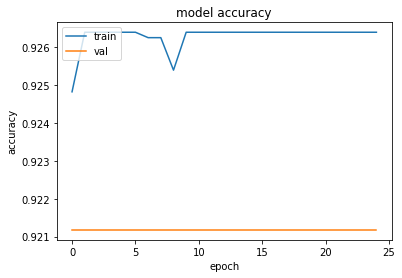

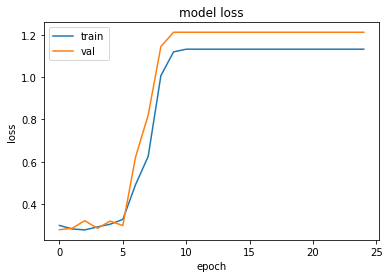

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
nn_kfold(df_medain_75_sub1)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 32)            2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 32)            128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 64)            4160      
_______________

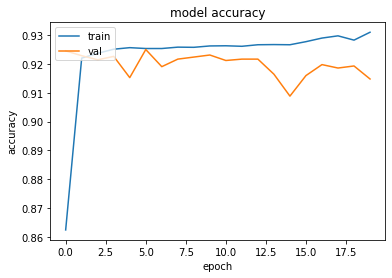

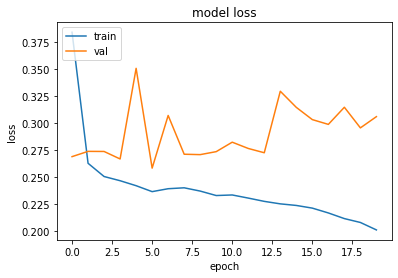

[[9476  105]
 [ 735   32]]
F1 score: 0.07079646017699115
Precision: 0.23357664233576642
Recall: 0.041720990873533245
Accuracy: 0.9188248936992656
ROC AUC: 0.5153809004049328


In [38]:
cnn(df_medain_75_sub1)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               6200      
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 176us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.672151562087658;  accuracy of 0.6041696667671204; precision of 0.6041696667671204; recall of 0.6041696667671204; AUC of 0.7040464282035828;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 175us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.740487880252624;  accuracy of 0.6904183626174927; precision of 0.6904183626174927; recall of 0.6904183626174927; AUC of 0.7169690132141113;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 174us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.7342980240611167;  accuracy of 0.596315860748291; precision of 0.596315860748291; recall of 0.596315860748291; AUC of 0.6596972346305847;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


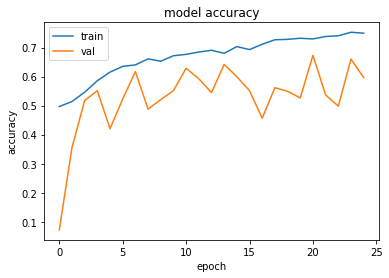

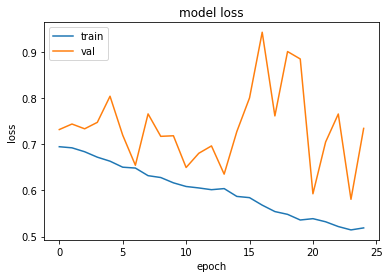

[[5688 3893]
 [ 316  451]]
F1 score: 0.1764820974369008
Precision: 0.10382136279926335
Recall: 0.5880052151238592
Accuracy: 0.5932547352145342
ROC AUC: 0.5908400984292712


In [39]:
nn_kfold(df_medain_75_sub1, balanced_batches=True)

Training data shape: (16807, 31)
Val data shape: (4202, 31)
Test data shape: (10348, 31)
Input shape: 30
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 29, 32)            128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 28, 32)            2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 32)            128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 27, 64)            4160      
_______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 16s 201ms/step - loss: 0.9074 - accuracy: 0.5803 - precision: 0.5803 - recall: 0.5803 - AUC: 0.6043 - val_loss: 0.6672 - val_accuracy: 0.7713 - val_precision: 0.7713 - val_recall: 0.7713 - val_AUC: 0.8232
Epoch 2/20
79/79 [==============================] - 8s 100ms/step - loss: 0.6582 - accuracy: 0.6450 - precision: 0.6450 - recall: 0.6450 - AUC: 0.7048 - val_loss: 0.6664 - val_accuracy: 0.6901 - val_precision: 0.6901 - val_recall: 0.6901 - val_AUC: 0.7364
Epoch 3/20
79/79 [==============================] - 8s 101ms/step - loss: 0.5917 - accuracy: 0.7025 - precision: 0.7025 - recall: 0.7025 - AUC: 0.7584 - val_loss: 0.7518 - val_accuracy: 0.3858 - val_precision: 0.3858 - val_recall: 0.3858 - val_AUC: 0.3303
Epoch 4/20
79/79 [==============================] - 8s 99ms/step - loss: 0.5555 - accuracy: 0.7085 - precision: 0.7085 - recall: 0.7085 - AUC: 0.7856 - val_loss: 0.7436 - val_accuracy: 0.4979 - val_precision: 0.4979 - val_recall: 0

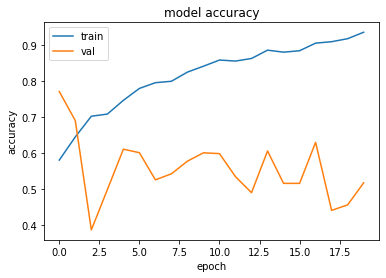

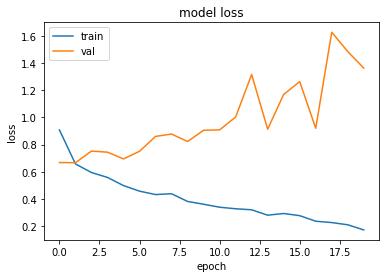

[[5070 4511]
 [ 282  485]]
F1 score: 0.16831511365608187
Precision: 0.09707766212970376
Recall: 0.6323337679269883
Accuracy: 0.5368187089292616
ROC AUC: 0.5807530440720423


In [40]:
cnn(df_medain_75_sub1, balanced_batches=True)

## Subset intuitively chosen 1/2

In [14]:
subset2 = ['depressed', 'race_ethnicity', 'edu_level', 'age', 'gender', 'annual_HI',
              'marital_status', 'special_diet', 'protein', 'carb','sugar', 'fiber', 'fat', 
               'diet_chol', 'VitB6', 'folate', 'VitB12', 'doc_diabetes','how_healthy_diet', 
               'used_CMH', 'gen_health_cond','healthcare_past_yr', 'run_out_food', 'afford_balanced_meals',
              'food_security_cat', 'food_stamps', 'doc_asthma','doc_overweight', 'doc_arthritis', 
               'doc_CHD','doc_heart_attack', 'doc_stroke', 'doc_chronic_bronchitis',
               'doc_liver_condition', 'doc_thyroid_problem', 'doc_cancer','anemia', 'doc_kidney',
               'work_type', 'embarassed_mouth', 'lab_B12', 'vigorous_activity','moderate_activity', 
               'hours_TV', 'hours_computer','manage_$_difficult', 'doc_sleeping_disorder','hrs_sleep',
              'smoked_5days', 'sexual_orientation','alcoholic', 'consider_weight','triglyceride', 'tot_cholesterol',
              'rbc_folate','fasting_glucose', 'lab_VitD','BMI','min_sedetary','difficult_remembering',
              'persistent_cold','lab_VitB12','difficult_errands', 'doc_COPD']

s2 = []
for s in subset2:
    if s in df_raw_medain_75_OG.columns:
        s2.append(s)

df_medain_75_sub2 = df_raw_medain_75_OG[s2]

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               20400     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 223us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.0696048406333765;  accuracy of 0.743538498878479; precision of 0.743538498878479; recall of 0.743538498878479; AUC of 0.8291670083999634;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 195us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.9428104945426156;  accuracy of 0.7756675481796265; precision of 0.7756675481796265; recall of 0.7756675481796265; AUC of 0.8391776084899902;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 185us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9513943540220957;  accuracy of 0.6877052783966064; precision of 0.6877052783966064; recall of 0.6877052783966064; AUC of 0.7315555810928345;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


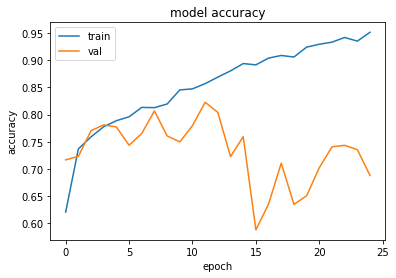

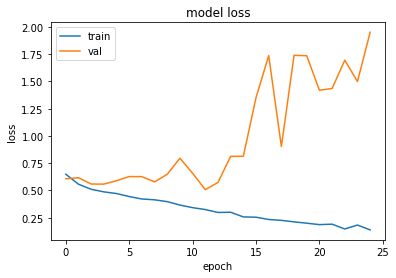

[[6463 3118]
 [ 209  558]]
F1 score: 0.2511816340310601
Precision: 0.15179542981501631
Recall: 0.727509778357236
Accuracy: 0.6784885968303054
ROC AUC: 0.7010370100428284


In [42]:
nn_kfold(df_medain_75_sub2, balanced_batches=True)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 101, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 99, 32)            2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 99, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 98, 64)            4160      
__________

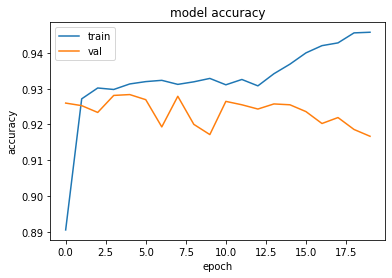

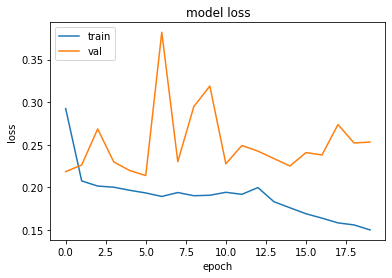

[[9279  302]
 [ 574  193]]
F1 score: 0.30586370839936605
Precision: 0.3898989898989899
Recall: 0.2516297262059974
Accuracy: 0.9153459605720913
ROC AUC: 0.6100545040590576


In [43]:
cnn(df_medain_75_sub2)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               20400     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 202us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.361271140201933;  accuracy of 0.7545337677001953; precision of 0.7545337677001953; recall of 0.7545337677001953; AUC of 0.7960035800933838;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 201us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.618241316332879;  accuracy of 0.6438668966293335; precision of 0.6438668966293335; recall of 0.6438668966293335; AUC of 0.6918281316757202;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 199us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.6198260688907706;  accuracy of 0.7373982667922974; precision of 0.7373982667922974; recall of 0.7373982667922974; AUC of 0.7575839161872864;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


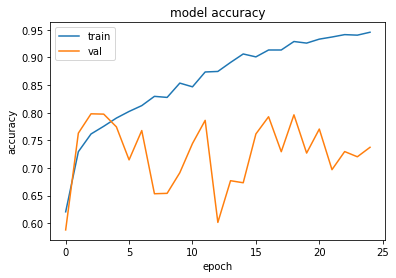

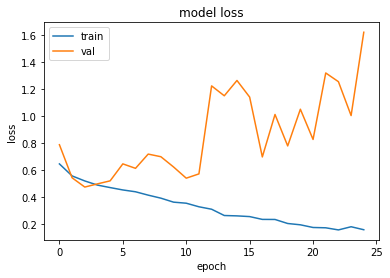

[[7026 2555]
 [ 238  529]]
F1 score: 0.274733835367437
Precision: 0.17153047989623865
Recall: 0.6897001303780965
Accuracy: 0.730092771550058
ROC AUC: 0.7115132527477582


In [44]:
nn_kfold(df_medain_75_sub2, balanced_batches=True)

Training data shape: (16807, 102)
Val data shape: (4202, 102)
Test data shape: (10348, 102)
Input shape: 101
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 101, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 100, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 100, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 99, 32)            2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 99, 32)            128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 98, 64)            4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 27s 345ms/step - loss: 0.7350 - accuracy: 0.6958 - precision: 0.6958 - recall: 0.6958 - AUC: 0.7593 - val_loss: 0.8001 - val_accuracy: 0.0885 - val_precision: 0.0885 - val_recall: 0.0885 - val_AUC: 0.1169
Epoch 2/20
79/79 [==============================] - 19s 246ms/step - loss: 0.5350 - accuracy: 0.7472 - precision: 0.7472 - recall: 0.7472 - AUC: 0.8242 - val_loss: 0.7762 - val_accuracy: 0.2932 - val_precision: 0.2932 - val_recall: 0.2932 - val_AUC: 0.2400
Epoch 3/20
79/79 [==============================] - 19s 246ms/step - loss: 0.4673 - accuracy: 0.7808 - precision: 0.7808 - recall: 0.7808 - AUC: 0.8596 - val_loss: 0.6567 - val_accuracy: 0.6352 - val_precision: 0.6352 - val_recall: 0.6352 - val_AUC: 0.6665
Epoch 4/20
79/79 [==============================] - 19s 246ms/step - loss: 0.4394 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - AUC: 0.8759 - val_loss: 0.5438 - val_accuracy: 0.7573 - val_precision: 0.7573 - val_recal

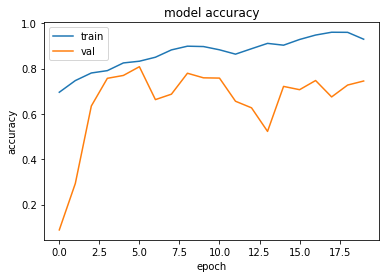

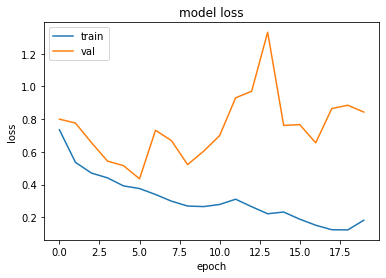

[[7244 2337]
 [ 269  498]]
F1 score: 0.2765130483064964
Precision: 0.17566137566137566
Recall: 0.6492829204693612
Accuracy: 0.7481638964051024
ROC AUC: 0.7026813308118646


In [45]:
cnn(df_medain_75_sub2, balanced_batches=True)

## Created new features (categorical)

In [15]:
df_raw_medain_75_ext =  pd.read_csv('df_median_75_feature_ext.csv')

df_ext_square = df_raw_medain_75_ext[df_raw_medain_75_ext.columns.drop(list(df_raw_medain_75_ext.filter(regex='_2')))]

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 200)               35200     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_103 (Dropout)        (None, 100)               0         
__________

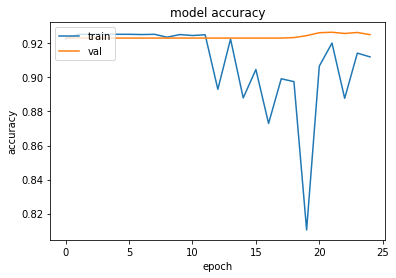

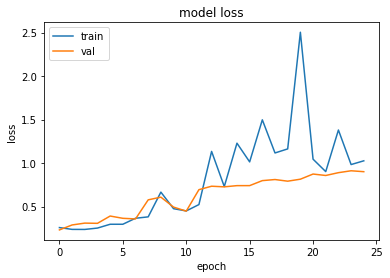

[[9492   89]
 [ 680   87]]
F1 score: 0.18451749734888653
Precision: 0.4943181818181818
Recall: 0.11342894393741851
Accuracy: 0.9256861229223038
ROC AUC: 0.5520698628464882


In [47]:
nn_kfold(df_ext_square)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 175, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 174, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 174, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 173, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 173, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 172, 64)           4160      
__________

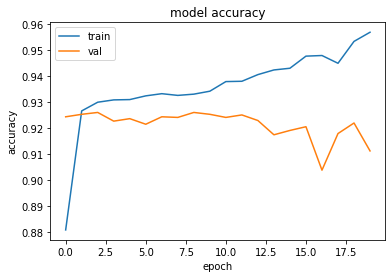

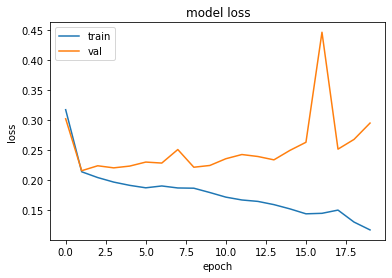

[[9137  444]
 [ 521  246]]
F1 score: 0.33768016472203155
Precision: 0.3565217391304348
Recall: 0.32073011734028684
Accuracy: 0.9067452647854658
ROC AUC: 0.6371941996783889


In [48]:
cnn(df_ext_square)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               35200     
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_128 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 282us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.029467528094126;  accuracy of 0.7161216735839844; precision of 0.7161216735839844; recall of 0.7161216735839844; AUC of 0.7473272681236267;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 232us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.2882156393263453;  accuracy of 0.764815092086792; precision of 0.764815092086792; recall of 0.764815092086792; AUC of 0.8257483839988708;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 230us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.3423293235726514;  accuracy of 0.7708125114440918; precision of 0.7708125114440918; recall of 0.7708125114440918; AUC of 0.840904712677002;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


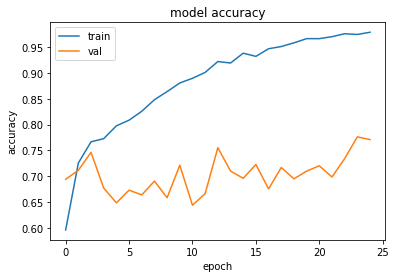

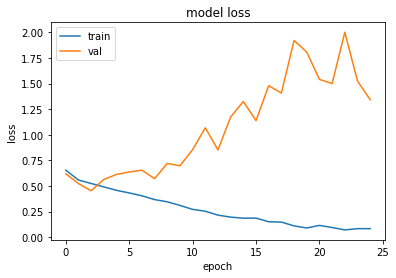

[[7485 2096]
 [ 277  490]]
F1 score: 0.29227557411273486
Precision: 0.18948182521268367
Recall: 0.6388526727509778
Accuracy: 0.7706803247004252
ROC AUC: 0.7100431822162153


In [49]:
nn_kfold(df_ext_square, balanced_batches=True)

Training data shape: (16807, 176)
Val data shape: (4202, 176)
Test data shape: (10348, 176)
Input shape: 175
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 175, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 174, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 174, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 173, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 173, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 172, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 41s 514ms/step - loss: 0.6610 - accuracy: 0.7124 - precision: 0.7124 - recall: 0.7124 - AUC: 0.7765 - val_loss: 0.7268 - val_accuracy: 0.1797 - val_precision: 0.1797 - val_recall: 0.1797 - val_AUC: 0.1519
Epoch 2/20
79/79 [==============================] - 32s 402ms/step - loss: 0.4947 - accuracy: 0.7644 - precision: 0.7644 - recall: 0.7644 - AUC: 0.8420 - val_loss: 0.7828 - val_accuracy: 0.0840 - val_precision: 0.0840 - val_recall: 0.0840 - val_AUC: 0.1171
Epoch 3/20
79/79 [==============================] - 32s 403ms/step - loss: 0.4501 - accuracy: 0.7887 - precision: 0.7887 - recall: 0.7887 - AUC: 0.8694 - val_loss: 0.8027 - val_accuracy: 0.2106 - val_precision: 0.2106 - val_recall: 0.2106 - val_AUC: 0.1755
Epoch 4/20
79/79 [==============================] - 32s 402ms/step - loss: 0.4171 - accuracy: 0.8175 - precision: 0.8175 - recall: 0.8175 - AUC: 0.8904 - val_loss: 0.6520 - val_accuracy: 0.6333 - val_precision: 0.6333 - val_recal

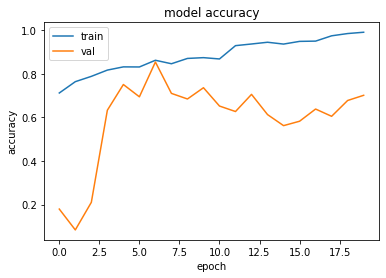

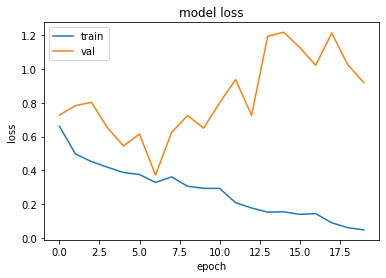

[[6836 2745]
 [ 231  536]]
F1 score: 0.2648221343873518
Precision: 0.16336482779640354
Recall: 0.6988265971316818
Accuracy: 0.7124081948202551
ROC AUC: 0.7061610284478992


In [50]:
cnn(df_ext_square, balanced_batches=True)

## Created + log(cont)

In [16]:
df_created_log = df_ext_square.copy()

cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_log[str(var) + '_log'] = (df_created_log[var]-df_created_log[var].min()+1).transform(np.log)


df_created_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_log,monthly_income_log,min_sedetary_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,0.693147,1.94591,5.70711,6.22059,0.318454,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,0.693147,1.94591,5.70711,6.22059,0.318454,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,0.693147,1.94591,5.70711,6.22059,0.318454,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,0.693147,1.94591,5.70711,6.22059,0.318454,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,0.693147,1.94591,5.70711,6.22059,0.318454,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 200)               45000     
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
__________

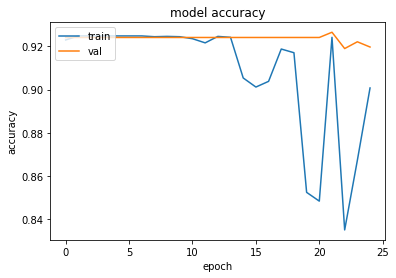

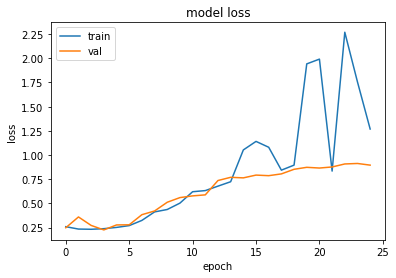

[[9351  230]
 [ 637  130]]
F1 score: 0.2307009760425909
Precision: 0.3611111111111111
Recall: 0.1694915254237288
Accuracy: 0.9162156938538848
ROC AUC: 0.5727428402611808


In [52]:
nn_kfold(df_created_log)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 221, 64)           4160      
__________

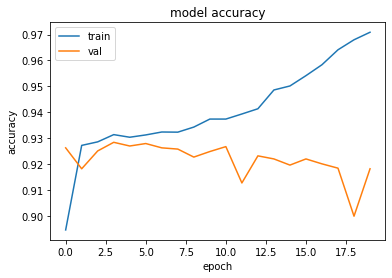

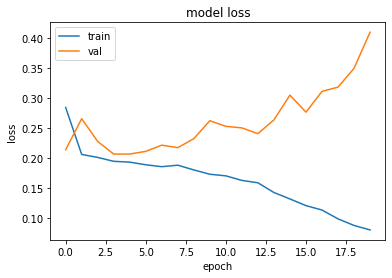

[[9375  206]
 [ 611  156]]
F1 score: 0.2763507528786537
Precision: 0.430939226519337
Recall: 0.2033898305084746
Accuracy: 0.9210475454194047
ROC AUC: 0.5909444716679727


In [53]:
cnn(df_created_log)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 200)               45000     
_________________________________________________________________
dropout_176 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_178 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 262us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.317349209770822;  accuracy of 0.7226902842521667; precision of 0.7226902842521667; recall of 0.7226902842521667; AUC of 0.7613510489463806;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 252us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.8143622879299048;  accuracy of 0.6734256744384766; precision of 0.6734256744384766; recall of 0.6734256744384766; AUC of 0.7182295322418213;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 241us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.308342387927152;  accuracy of 0.7372554540634155; precision of 0.7372554540634155; recall of 0.7372554540634155; AUC of 0.7892038822174072;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


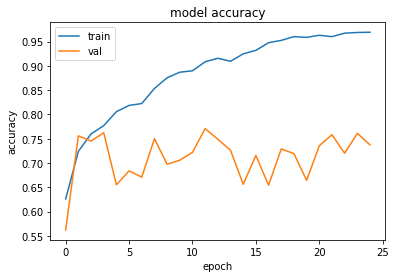

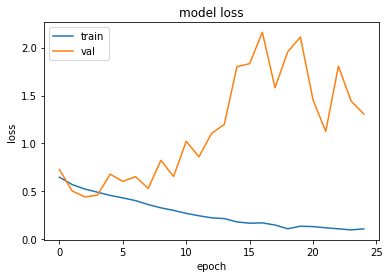

[[6988 2593]
 [ 248  519]]
F1 score: 0.2675947409126063
Precision: 0.16677377892030848
Recall: 0.6766623207301173
Accuracy: 0.7254541940471588
ROC AUC: 0.7030112563884383


In [54]:
nn_kfold(df_created_log, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 221, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 51s 650ms/step - loss: 0.6953 - accuracy: 0.6986 - precision: 0.6986 - recall: 0.6986 - AUC: 0.7602 - val_loss: 0.6624 - val_accuracy: 0.8327 - val_precision: 0.8327 - val_recall: 0.8327 - val_AUC: 0.9072
Epoch 2/20
79/79 [==============================] - 40s 509ms/step - loss: 0.5015 - accuracy: 0.7720 - precision: 0.7720 - recall: 0.7720 - AUC: 0.8400 - val_loss: 0.6833 - val_accuracy: 0.6045 - val_precision: 0.6045 - val_recall: 0.6045 - val_AUC: 0.6204
Epoch 3/20
79/79 [==============================] - 40s 509ms/step - loss: 0.4707 - accuracy: 0.7752 - precision: 0.7752 - recall: 0.7752 - AUC: 0.8584 - val_loss: 0.7914 - val_accuracy: 0.3237 - val_precision: 0.3237 - val_recall: 0.3237 - val_AUC: 0.2693
Epoch 4/20
79/79 [==============================] - 40s 509ms/step - loss: 0.4211 - accuracy: 0.8067 - precision: 0.8067 - recall: 0.8067 - AUC: 0.8868 - val_loss: 0.7165 - val_accuracy: 0.5402 - val_precision: 0.5402 - val_recal

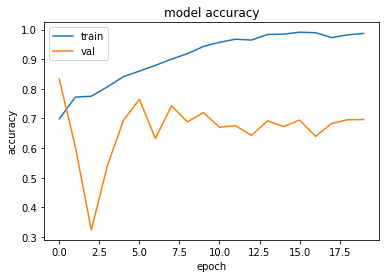

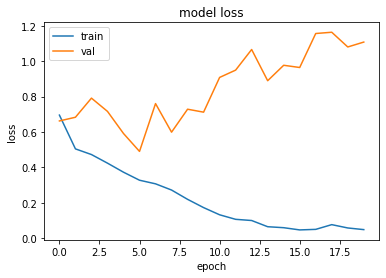

[[6631 2950]
 [ 225  542]]
F1 score: 0.25451984033810754
Precision: 0.1552119129438717
Recall: 0.7066492829204694
Accuracy: 0.6931774255894859
ROC AUC: 0.6993741143753791


In [55]:
cnn(df_created_log, balanced_batches=True)

## Created + sqrt

In [17]:
df_created_sqrt = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sqrt[str(var) + '_sqrt'] = (df_created_sqrt[var]-df_created_sqrt[var].min()+1).transform(np.sqrt)


df_created_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sqrt,monthly_income_sqrt,min_sedetary_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_233 (Dense)            (None, 200)               45000     
_________________________________________________________________
dropout_201 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_202 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_203 (Dropout)        (None, 100)               0         
__________

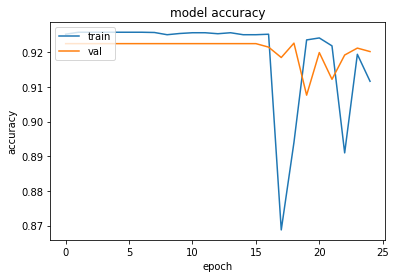

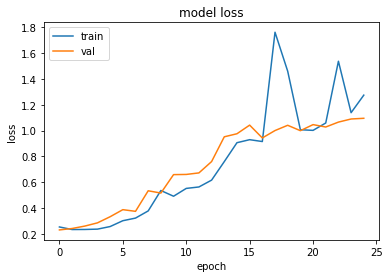

[[9474  107]
 [ 694   73]]
F1 score: 0.15417106652587118
Precision: 0.40555555555555556
Recall: 0.09517601043024772
Accuracy: 0.9225937379203711
ROC AUC: 0.5420040369445884


In [57]:
nn_kfold(df_created_sqrt)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 224, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 221, 64)           4160      
__________

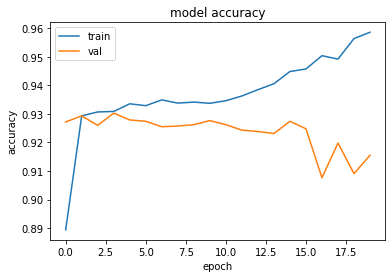

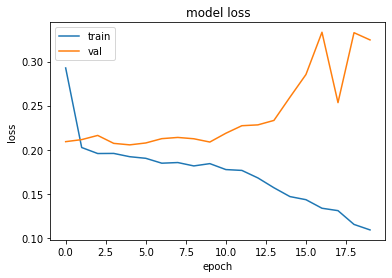

[[9219  362]
 [ 568  199]]
F1 score: 0.2996987951807229
Precision: 0.35472370766488415
Recall: 0.25945241199478486
Accuracy: 0.9101275608813297
ROC AUC: 0.6108346497924034


In [58]:
cnn(df_created_sqrt)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 200)               45000     
_________________________________________________________________
dropout_226 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_227 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_228 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 275us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.6556185338389238;  accuracy of 0.7254034280776978; precision of 0.7254034280776978; recall of 0.7254034280776978; AUC of 0.7988119721412659;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 259us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.2752891116511322;  accuracy of 0.7745252251625061; precision of 0.7745252251625061; recall of 0.7745252251625061; AUC of 0.8292945623397827;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 304us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.4967914541397846;  accuracy of 0.6947022676467896; precision of 0.6947022676467896; recall of 0.6947022676467896; AUC of 0.7439624667167664;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


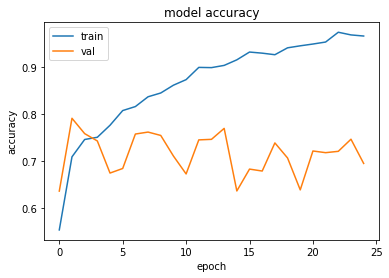

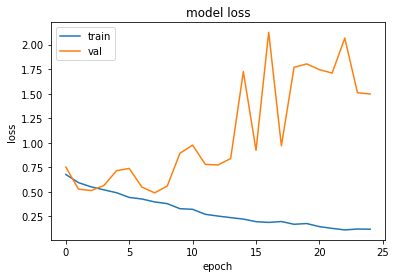

[[6483 3098]
 [ 230  537]]
F1 score: 0.24398000908677875
Precision: 0.14773039889958733
Recall: 0.7001303780964798
Accuracy: 0.678391959798995
ROC AUC: 0.6883910422994663


In [59]:
nn_kfold(df_created_sqrt, balanced_batches=True)

Training data shape: (16807, 225)
Val data shape: (4202, 225)
Test data shape: (10348, 225)
Input shape: 224
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 224, 1)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 223, 32)           96        
_________________________________________________________________
batch_normalization_46 (Batc (None, 223, 32)           128       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 222, 32)           2080      
_________________________________________________________________
batch_normalization_47 (Batc (None, 222, 32)           128       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 221, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 53s 674ms/step - loss: 0.6812 - accuracy: 0.7037 - precision: 0.7037 - recall: 0.7037 - AUC: 0.7649 - val_loss: 0.8524 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.1157
Epoch 2/20
79/79 [==============================] - 40s 508ms/step - loss: 0.4988 - accuracy: 0.7728 - precision: 0.7728 - recall: 0.7728 - AUC: 0.8414 - val_loss: 0.8022 - val_accuracy: 0.1575 - val_precision: 0.1575 - val_recall: 0.1575 - val_AUC: 0.1457
Epoch 3/20
79/79 [==============================] - 40s 507ms/step - loss: 0.4833 - accuracy: 0.7792 - precision: 0.7792 - recall: 0.7792 - AUC: 0.8522 - val_loss: 0.8975 - val_accuracy: 0.1856 - val_precision: 0.1856 - val_recall: 0.1856 - val_AUC: 0.1646
Epoch 4/20
79/79 [==============================] - 40s 511ms/step - loss: 0.4220 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - AUC: 0.8866 - val_loss: 0.6719 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recal

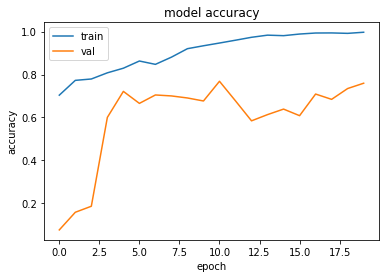

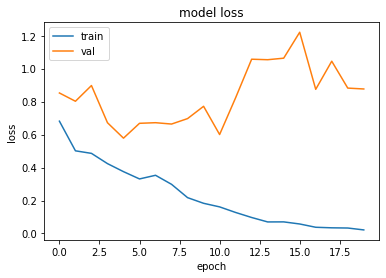

[[7317 2264]
 [ 276  491]]
F1 score: 0.2788188529244747
Precision: 0.1782214156079855
Recall: 0.6401564537157758
Accuracy: 0.7545419404715887
ROC AUC: 0.7019277206476802


In [60]:
cnn(df_created_sqrt, balanced_batches=True)

## subset of created columns - minimize correlation

In [18]:
subset_corr = ['depressed', 'broken_hip','edu_level', 'gender', 'marital_status', 'protein', 
       'sugar', 'fiber', 'fat', 'magnesium', 'iron', 'zinc', 'selenium', 'water', 
       'how_healthy_diet', 'gen_health_cond', 'healthcare_past_yr', 'health_insurance',
        'home_ownership', 'food_security_cat', 'work_type', 'hrs_worked_week',
       'embarassed_mouth', 'manage_$_difficult', 'doc_sleeping_disorder',
       'hrs_sleep', 'smoked_5days', 'sexual_orientation',  'consider_weight','triglyceride', 
               'tot_cholesterol', 'rbc_folate',
       'fasting_glucose', 'lab_VitD', 'pulse', 'BMI', 
       'monthly_income', 'oral_rec', 'difficult_remembering', 'prob_smell', 'prob_tatse',
       'persistent_cold',  'serum_selenium', 'serum_zinc', 'serum_creatinine', 'lab_VitB12',
        'doc_COPD', 'age_cat', 'not_enough_food', 'food_welfare', 'chronic_condition',
       '#_chronic_condition', 'active', 'hours_screen', 'limited',
       'taste_smell', 'difficult_everyday', 'combined_BP',
       'drugs_alcohol', 'people_per_rooms', 'sexuality', 'race_cat',
       'diet_tot_VitB']

s3 = []
for s in subset_corr:
    if s in df_ext_square.columns:
        s3.append(s)

df_min_corr = df_ext_square[s3]

In [62]:
df_min_corr.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,active,hours_screen,limited,difficult_everyday,combined_BP,drugs_alcohol,people_per_rooms,sexuality,race_cat,diet_tot_VitB
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,0.0,2.0,0.0,0.0,218.0,0.0,0.500000,0.0,3.0,300.415
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,1.0,2.0,0.0,0.0,198.0,0.0,0.250000,0.0,2.0,814.422
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,1.0,1.0,0.0,0.0,198.0,0.0,0.285714,0.0,2.0,288.623
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,1.0,8.0,0.0,0.0,174.0,0.0,0.375000,0.0,1.0,308.428
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,1.0,6.0,0.0,0.0,170.0,0.0,0.428571,0.0,2.0,536.671


Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 200)               19600     
_________________________________________________________________
dropout_251 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_292 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_252 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_293 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_253 (Dropout)        (None, 100)               0         
______________

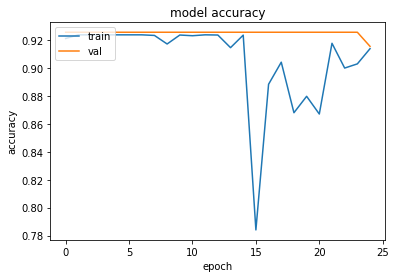

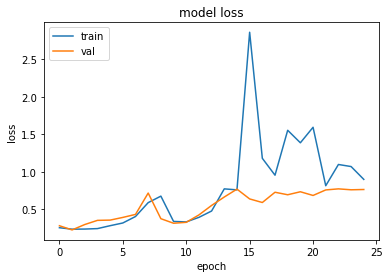

[[9241  340]
 [ 574  193]]
F1 score: 0.29692307692307685
Precision: 0.3621013133208255
Recall: 0.2516297262059974
Accuracy: 0.9116737533822961
ROC AUC: 0.6080714125237272


In [63]:
nn_kfold(df_min_corr)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 97, 1)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 96, 32)            96        
_________________________________________________________________
batch_normalization_51 (Batc (None, 96, 32)            128       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 95, 32)            2080      
_________________________________________________________________
batch_normalization_52 (Batc (None, 95, 32)            128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 94, 64)            4160      
______________

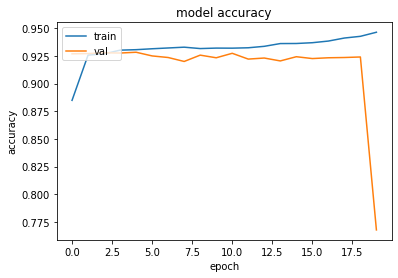

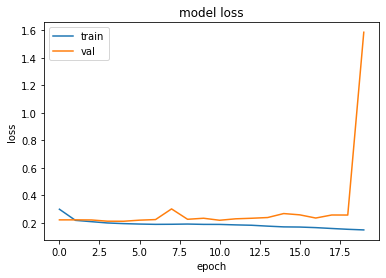

[[7504 2077]
 [ 336  431]]
F1 score: 0.263206106870229
Precision: 0.1718500797448166
Recall: 0.5619295958279009
Accuracy: 0.7668148434480093
ROC AUC: 0.6725731895223421


In [64]:
cnn(df_min_corr)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            (None, 200)               19600     
_________________________________________________________________
dropout_276 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_277 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_322 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_278 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 265us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.3638510437296336;  accuracy of 0.7162644863128662; precision of 0.7162644863128662; recall of 0.7162644863128662; AUC of 0.7638663649559021;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 308us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.7589845190503742;  accuracy of 0.7756675481796265; precision of 0.7756675481796265; recall of 0.7756675481796265; AUC of 0.8518090844154358;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 270us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9292469688880176;  accuracy of 0.6834213733673096; precision of 0.6834213733673096; recall of 0.6834213733673096; AUC of 0.7246244549751282;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


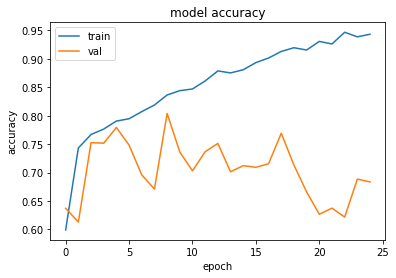

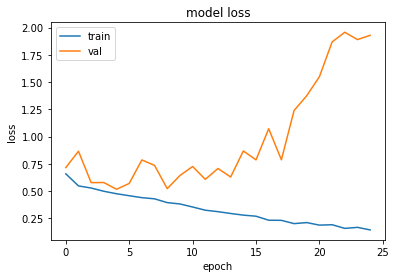

[[6455 3126]
 [ 185  582]]
F1 score: 0.26011173184357544
Precision: 0.156957928802589
Recall: 0.758800521512386
Accuracy: 0.6800347893312717
ROC AUC: 0.7162648886655971


In [65]:
nn_kfold(df_min_corr, balanced_batches=True)

Training data shape: (16807, 98)
Val data shape: (4202, 98)
Test data shape: (10348, 98)
Input shape: 97
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 97, 1)             0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 96, 32)            96        
_________________________________________________________________
batch_normalization_56 (Batc (None, 96, 32)            128       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 95, 32)            2080      
_________________________________________________________________
batch_normalization_57 (Batc (None, 95, 32)            128       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 94, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 30s 375ms/step - loss: 0.6941 - accuracy: 0.7033 - precision: 0.7033 - recall: 0.7033 - AUC: 0.7673 - val_loss: 0.6114 - val_accuracy: 0.9255 - val_precision: 0.9255 - val_recall: 0.9255 - val_AUC: 0.9664
Epoch 2/20
79/79 [==============================] - 19s 245ms/step - loss: 0.5236 - accuracy: 0.7484 - precision: 0.7484 - recall: 0.7484 - AUC: 0.8277 - val_loss: 0.5756 - val_accuracy: 0.9017 - val_precision: 0.9017 - val_recall: 0.9017 - val_AUC: 0.9583
Epoch 3/20
79/79 [==============================] - 19s 245ms/step - loss: 0.4572 - accuracy: 0.7800 - precision: 0.7800 - recall: 0.7800 - AUC: 0.8658 - val_loss: 0.5770 - val_accuracy: 0.7941 - val_precision: 0.7941 - val_recall: 0.7941 - val_AUC: 0.8668
Epoch 4/20
79/79 [==============================] - 19s 245ms/step - loss: 0.4215 - accuracy: 0.8003 - precision: 0.8003 - recall: 0.8003 - AUC: 0.8858 - val_loss: 0.5085 - val_accuracy: 0.7887 - val_precision: 0.7887 - val_recal

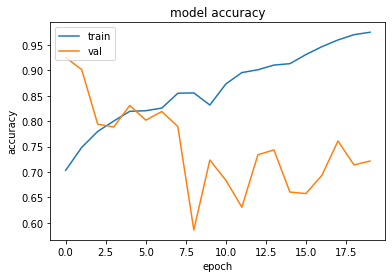

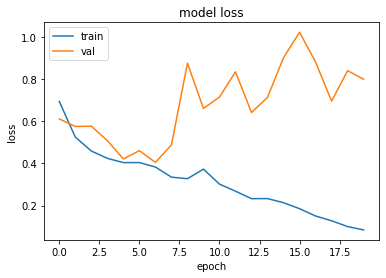

[[7062 2519]
 [ 263  504]]
F1 score: 0.26596306068601583
Precision: 0.1667217995368839
Recall: 0.6571056062581486
Accuracy: 0.7311557788944724
ROC AUC: 0.697094708984413


In [66]:
cnn(df_min_corr, balanced_batches=True)

## Subset of created + log

In [19]:
df_sub_log = df_min_corr.copy()

cont, non_cont, cat_encode, = var_type(df_sub_log)

# log of all cont columns
for var in cont:
    df_sub_log[str(var) + '_log'] = (df_sub_log[var]-df_sub_log[var].min()+1).transform(np.log)


df_sub_log.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,lab_VitD_log,pulse_log,BMI_log,monthly_income_log,lab_VitB12_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,3.496811,3.135494,2.929592,1.94591,6.22059,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,4.238589,3.295837,2.530517,1.94591,6.22059,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,3.629925,2.708050,2.915064,1.94591,6.22059,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,4.014760,3.496508,2.848971,1.94591,6.22059,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,3.752089,3.496508,2.340844,1.94591,6.22059,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_349 (Dense)            (None, 200)               25000     
_________________________________________________________________
dropout_301 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_350 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_302 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_303 (Dropout)        (None, 100)               0         
__________

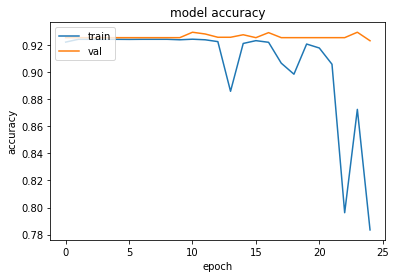

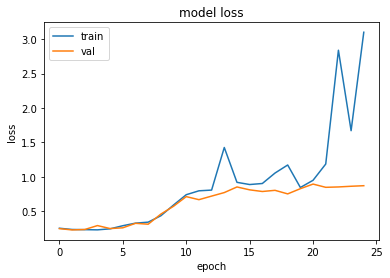

[[9381  200]
 [ 640  127]]
F1 score: 0.2321755027422303
Precision: 0.38837920489296635
Recall: 0.16558018252933507
Accuracy: 0.9188248936992656
ROC AUC: 0.5723527673945078


In [68]:
nn_kfold(df_sub_log)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 124, 1)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 123, 32)           96        
_________________________________________________________________
batch_normalization_61 (Batc (None, 123, 32)           128       
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 122, 32)           2080      
_________________________________________________________________
batch_normalization_62 (Batc (None, 122, 32)           128       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 121, 64)           4160      
__________

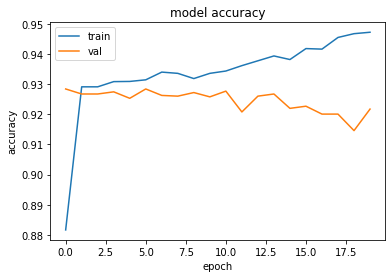

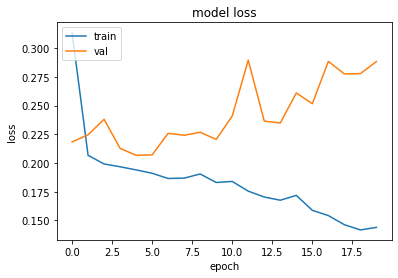

[[9391  190]
 [ 607  160]]
F1 score: 0.28648164726947184
Precision: 0.45714285714285713
Recall: 0.20860495436766624
Accuracy: 0.9229802860456127
ROC AUC: 0.5943870195071814


In [69]:
cnn(df_sub_log)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_378 (Dense)            (None, 200)               25000     
_________________________________________________________________
dropout_326 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_379 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_327 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_380 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_328 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 282us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.9608422108893563;  accuracy of 0.7441096901893616; precision of 0.7441096901893616; recall of 0.7441096901893616; AUC of 0.8282127976417542;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 294us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0835458465802505;  accuracy of 0.781665027141571; precision of 0.781665027141571; recall of 0.781665027141571; AUC of 0.8313663005828857;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 292us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.9610883830599013;  accuracy of 0.7401114106178284; precision of 0.7401114106178284; recall of 0.7401114106178284; AUC of 0.8091844320297241;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


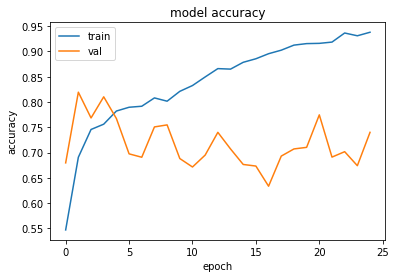

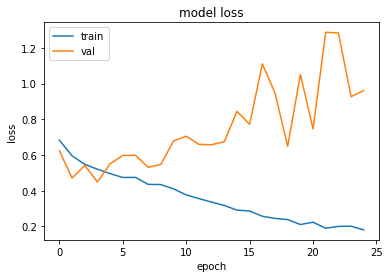

[[7004 2577]
 [ 244  523]]
F1 score: 0.27049392293767777
Precision: 0.16870967741935483
Recall: 0.681877444589309
Accuracy: 0.7273869346733668
ROC AUC: 0.7064538042276469


In [70]:
nn_kfold(df_sub_log, balanced_batches=True)

Training data shape: (16807, 125)
Val data shape: (4202, 125)
Test data shape: (10348, 125)
Input shape: 124
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 124, 1)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 123, 32)           96        
_________________________________________________________________
batch_normalization_66 (Batc (None, 123, 32)           128       
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 122, 32)           2080      
_________________________________________________________________
batch_normalization_67 (Batc (None, 122, 32)           128       
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 121, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 38s 482ms/step - loss: 0.7486 - accuracy: 0.6978 - precision: 0.6978 - recall: 0.6978 - AUC: 0.7590 - val_loss: 0.4340 - val_accuracy: 0.9243 - val_precision: 0.9243 - val_recall: 0.9243 - val_AUC: 0.9616
Epoch 2/20
79/79 [==============================] - 24s 302ms/step - loss: 0.5468 - accuracy: 0.7468 - precision: 0.7468 - recall: 0.7468 - AUC: 0.8198 - val_loss: 0.7267 - val_accuracy: 0.4043 - val_precision: 0.4043 - val_recall: 0.4043 - val_AUC: 0.3579
Epoch 3/20
79/79 [==============================] - 24s 302ms/step - loss: 0.4646 - accuracy: 0.7819 - precision: 0.7819 - recall: 0.7819 - AUC: 0.8623 - val_loss: 0.5748 - val_accuracy: 0.7623 - val_precision: 0.7623 - val_recall: 0.7623 - val_AUC: 0.8336
Epoch 4/20
79/79 [==============================] - 24s 302ms/step - loss: 0.4386 - accuracy: 0.7971 - precision: 0.7971 - recall: 0.7971 - AUC: 0.8784 - val_loss: 0.6634 - val_accuracy: 0.6197 - val_precision: 0.6197 - val_recal

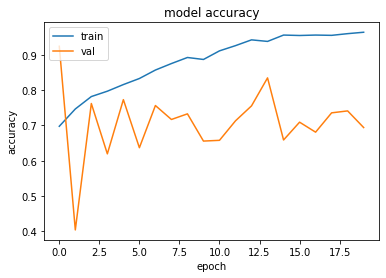

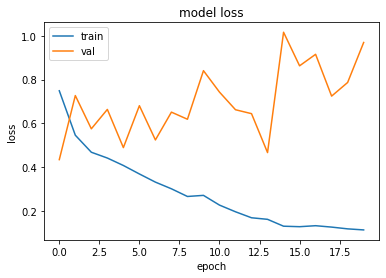

[[6587 2994]
 [ 210  557]]
F1 score: 0.25798981009726724
Precision: 0.1568572233173754
Recall: 0.7262059973924381
Accuracy: 0.6903749516814843
ROC AUC: 0.7068562603599285


In [71]:
cnn(df_sub_log, balanced_batches=True)

## Subset + log + sqrt

In [20]:
df_sub_log_sqrt = df_sub_log.copy()

# cont, non_cont, cat_encode, = var_type(df_sub_log_sqrt)

# log of all cont columns
for var in cont:
    df_sub_log_sqrt[str(var) + '_sqrt'] = (df_sub_log_sqrt[var]-df_sub_log_sqrt[var].min()+1).transform(np.sqrt)


df_sub_log_sqrt.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,lab_VitD_sqrt,pulse_sqrt,BMI_sqrt,monthly_income_sqrt,lab_VitB12_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,5.745433,4.795832,4.326662,2.645751,22.427661,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,8.325263,5.196152,3.544009,2.645751,22.427661,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,6.140847,3.872983,4.295346,2.645751,22.427661,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,7.443789,5.744563,4.155719,2.645751,22.427661,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,6.527634,5.744563,3.223352,2.645751,22.427661,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_407 (Dense)            (None, 200)               30400     
_________________________________________________________________
dropout_351 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_408 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_352 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_409 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_353 (Dropout)        (None, 100)               0         
__________

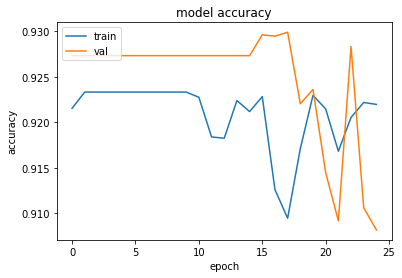

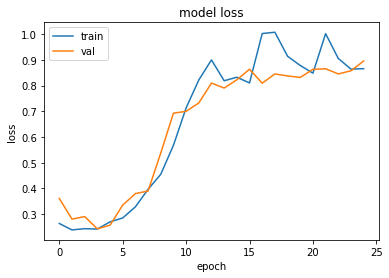

[[9183  398]
 [ 594  173]]
F1 score: 0.25859491778774285
Precision: 0.30297723292469353
Recall: 0.2255541069100391
Accuracy: 0.904136064940085
ROC AUC: 0.5920067789534017


In [73]:
nn_kfold(df_sub_log_sqrt)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_15 (Reshape)         (None, 151, 1)            0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 150, 32)           96        
_________________________________________________________________
batch_normalization_71 (Batc (None, 150, 32)           128       
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 149, 32)           2080      
_________________________________________________________________
batch_normalization_72 (Batc (None, 149, 32)           128       
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 148, 64)           4160      
__________

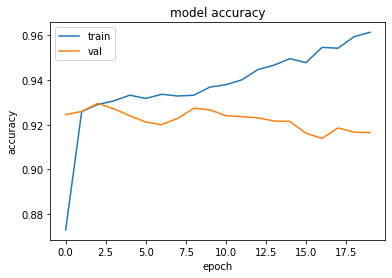

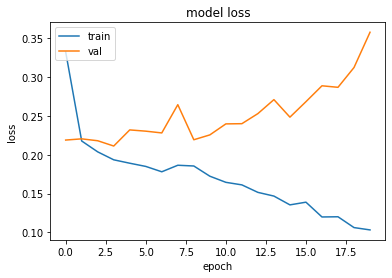

[[9322  259]
 [ 597  170]]
F1 score: 0.2842809364548495
Precision: 0.3962703962703963
Recall: 0.22164276401564537
Accuracy: 0.9172787011982992
ROC AUC: 0.5973050475959659


In [74]:
cnn(df_sub_log_sqrt)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_436 (Dense)            (None, 200)               30400     
_________________________________________________________________
dropout_376 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_437 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_377 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_438 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_378 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 319us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.10970203477826;  accuracy of 0.7592460513114929; precision of 0.7592460513114929; recall of 0.7592460513114929; AUC of 0.8290749192237854;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 313us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.14772727265454;  accuracy of 0.675567626953125; precision of 0.675567626953125; recall of 0.675567626953125; AUC of 0.684528648853302;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 336us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.9066732662942568;  accuracy of 0.7326859831809998; precision of 0.7326859831809998; recall of 0.7326859831809998; AUC of 0.8071485161781311;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


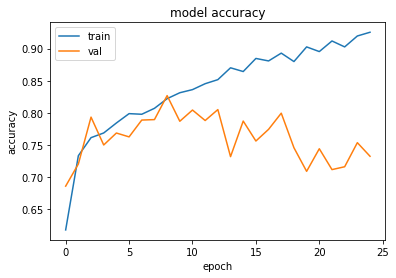

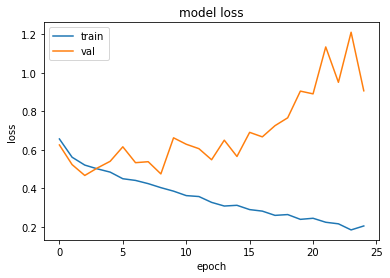

[[6842 2739]
 [ 209  558]]
F1 score: 0.27460629921259844
Precision: 0.16924476797088261
Recall: 0.727509778357236
Accuracy: 0.7151140316969463
ROC AUC: 0.720815738776781


In [75]:
nn_kfold(df_sub_log_sqrt, balanced_batches=True)

Training data shape: (16807, 152)
Val data shape: (4202, 152)
Test data shape: (10348, 152)
Input shape: 151
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 151, 1)            0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 150, 32)           96        
_________________________________________________________________
batch_normalization_76 (Batc (None, 150, 32)           128       
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 149, 32)           2080      
_________________________________________________________________
batch_normalization_77 (Batc (None, 149, 32)           128       
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 148, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 44s 551ms/step - loss: 0.7011 - accuracy: 0.7140 - precision: 0.7140 - recall: 0.7140 - AUC: 0.7689 - val_loss: 0.8423 - val_accuracy: 0.0754 - val_precision: 0.0754 - val_recall: 0.0754 - val_AUC: 0.1087
Epoch 2/20
79/79 [==============================] - 28s 360ms/step - loss: 0.5488 - accuracy: 0.7432 - precision: 0.7432 - recall: 0.7432 - AUC: 0.8146 - val_loss: 0.9187 - val_accuracy: 0.0776 - val_precision: 0.0776 - val_recall: 0.0776 - val_AUC: 0.1110
Epoch 3/20
79/79 [==============================] - 29s 364ms/step - loss: 0.4801 - accuracy: 0.7728 - precision: 0.7728 - recall: 0.7728 - AUC: 0.8508 - val_loss: 0.7345 - val_accuracy: 0.4117 - val_precision: 0.4117 - val_recall: 0.4117 - val_AUC: 0.3807
Epoch 4/20
79/79 [==============================] - 29s 364ms/step - loss: 0.4362 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - AUC: 0.8789 - val_loss: 0.7261 - val_accuracy: 0.5326 - val_precision: 0.5326 - val_recal

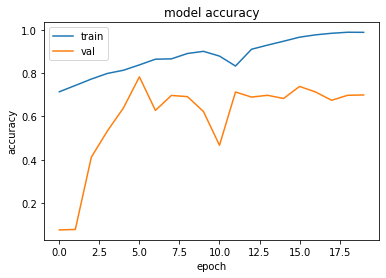

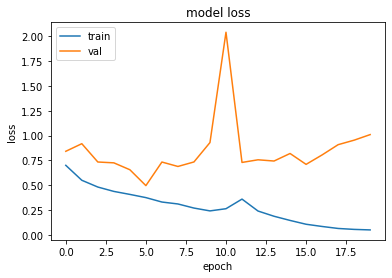

[[6636 2945]
 [ 220  547]]
F1 score: 0.25686780934491665
Precision: 0.15664375715922108
Recall: 0.7131681877444589
Accuracy: 0.6941437959025899
ROC AUC: 0.702894499884128


In [76]:
cnn(df_sub_log_sqrt, balanced_batches=True)

## All created + polynomial

In [21]:
df_created_poly = df_ext_square.copy()

# 1+5x+8x2
for var in cont:
    df_created_poly[str(var) + '_poly'] = (1+(5*df_created_poly[var])+(8*np.power(df_created_poly[var],2)))


df_created_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,lab_VitD_poly,pulse_poly,BMI_poly,monthly_income_poly,lab_VitB12_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,11438.50,27203.0,7793.9800,428.0,2165801.0,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,43941.52,31063.0,5021.2408,428.0,2165801.0,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,14458.72,20251.0,7659.7252,428.0,2165801.0,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,29004.58,37333.0,7086.6700,428.0,2165801.0,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,17983.78,37333.0,4189.0892,428.0,2165801.0,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_465 (Dense)            (None, 200)               40600     
_________________________________________________________________
dropout_401 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_466 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_402 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_467 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_403 (Dropout)        (None, 100)               0         
__________

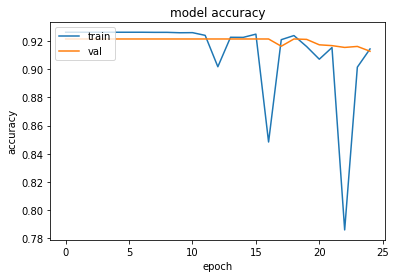

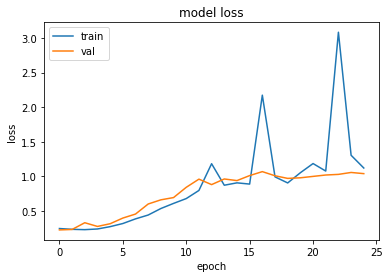

[[9313  268]
 [ 649  118]]
F1 score: 0.204683434518647
Precision: 0.30569948186528495
Recall: 0.15384615384615385
Accuracy: 0.9113838422883649
ROC AUC: 0.5629370629370629


In [78]:
nn_kfold(df_created_poly)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 202, 1)            0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 201, 32)           96        
_________________________________________________________________
batch_normalization_81 (Batc (None, 201, 32)           128       
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 200, 32)           2080      
_________________________________________________________________
batch_normalization_82 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 199, 64)           4160      
__________

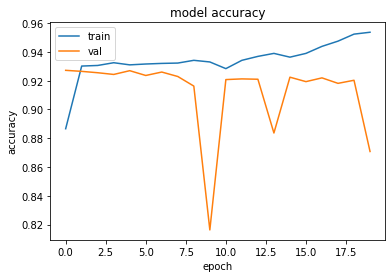

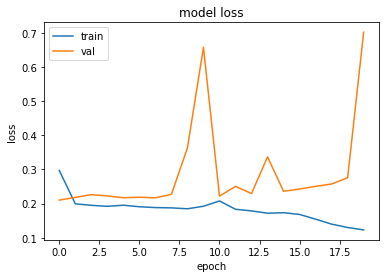

[[8670  911]
 [ 469  298]]
F1 score: 0.3016194331983806
Precision: 0.24648469809760132
Recall: 0.38852672750977835
Accuracy: 0.8666408967916506
ROC AUC: 0.6467213535263118


In [79]:
cnn(df_created_poly)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_494 (Dense)            (None, 200)               40600     
_________________________________________________________________
dropout_426 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_495 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_427 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_496 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_428 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 326us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.9827020844442238;  accuracy of 0.6832786202430725; precision of 0.6832786202430725; recall of 0.6832786202430725; AUC of 0.7396213412284851;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 328us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.53264094832351;  accuracy of 0.6354419589042664; precision of 0.6354419589042664; recall of 0.6354419589042664; AUC of 0.6419947147369385;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 323us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.20633358545479;  accuracy of 0.7318292260169983; precision of 0.7318292260169983; recall of 0.7318292260169983; AUC of 0.7948054671287537;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


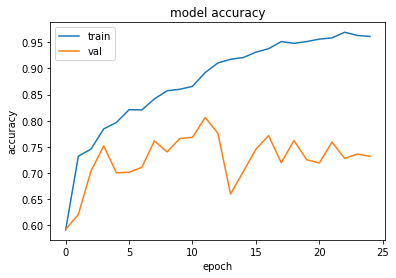

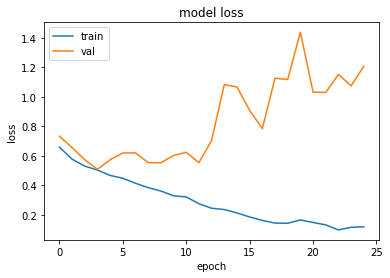

[[6946 2635]
 [ 238  529]]
F1 score: 0.2691427117781735
Precision: 0.16719342604298357
Recall: 0.6897001303780965
Accuracy: 0.7223618090452262
ROC AUC: 0.7073383231996945


In [80]:
nn_kfold(df_created_poly, balanced_batches=True)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 202, 1)            0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 201, 32)           96        
_________________________________________________________________
batch_normalization_86 (Batc (None, 201, 32)           128       
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 200, 32)           2080      
_________________________________________________________________
batch_normalization_87 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 199, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 49s 618ms/step - loss: 0.6754 - accuracy: 0.6978 - precision: 0.6978 - recall: 0.6978 - AUC: 0.7615 - val_loss: 0.6049 - val_accuracy: 0.9262 - val_precision: 0.9262 - val_recall: 0.9262 - val_AUC: 0.9662
Epoch 2/20
79/79 [==============================] - 37s 472ms/step - loss: 0.4911 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - AUC: 0.8435 - val_loss: 0.5595 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062 - val_AUC: 0.9608
Epoch 3/20
79/79 [==============================] - 37s 467ms/step - loss: 0.4621 - accuracy: 0.7792 - precision: 0.7792 - recall: 0.7792 - AUC: 0.8630 - val_loss: 0.5506 - val_accuracy: 0.7927 - val_precision: 0.7927 - val_recall: 0.7927 - val_AUC: 0.8782
Epoch 4/20
79/79 [==============================] - 37s 470ms/step - loss: 0.4347 - accuracy: 0.7979 - precision: 0.7979 - recall: 0.7979 - AUC: 0.8783 - val_loss: 0.6168 - val_accuracy: 0.6942 - val_precision: 0.6942 - val_recal

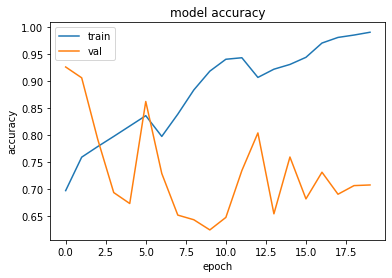

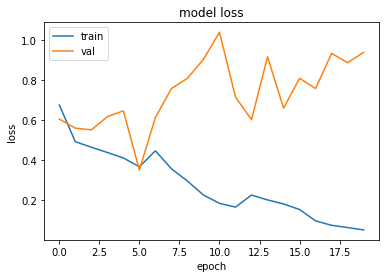

[[6869 2712]
 [ 242  525]]
F1 score: 0.26223776223776224
Precision: 0.16218721037998146
Recall: 0.6844850065189049
Accuracy: 0.7145342095090839
ROC AUC: 0.700712391580087


In [81]:
cnn(df_created_poly, balanced_batches=True)

## Created +sin()

In [22]:
df_created_sin = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sin[str(var) + '_sin'] = np.sin(df_created_sin[var])


df_created_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,lab_VitD_sin,pulse_sin,BMI_sin,monthly_income_sin,lab_VitB12_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,-0.197799,0.992873,-0.493341,0.656987,-0.997795,0.841471,0.909297,-0.942525,0.479426,-0.923802
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,-0.999624,-0.739181,-0.382722,0.656987,-0.997795,0.909297,0.909297,-0.079579,0.247404,-0.681275
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,-0.977717,-0.262375,-0.707480,0.656987,-0.997795,0.841471,0.841471,-0.079579,0.281843,-0.392662
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,-0.208205,-0.897928,-0.922946,0.656987,-0.997795,0.909297,0.989358,-0.936462,0.366273,0.524323
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,0.023888,-0.897928,-0.547063,0.656987,-0.997795,0.000000,-0.279415,0.346649,0.415572,0.515288


Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_523 (Dense)            (None, 200)               40600     
_________________________________________________________________
dropout_451 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_524 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_452 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_525 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_453 (Dropout)        (None, 100)               0         
__________

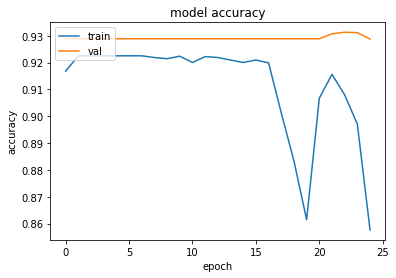

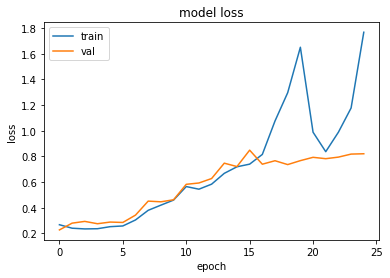

[[9498   83]
 [ 677   90]]
F1 score: 0.19148936170212763
Precision: 0.5202312138728323
Recall: 0.11734028683181226
Accuracy: 0.9265558562040974
ROC AUC: 0.5543386540097899


In [83]:
nn_kfold(df_created_sin)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 202, 1)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 201, 32)           96        
_________________________________________________________________
batch_normalization_91 (Batc (None, 201, 32)           128       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 200, 32)           2080      
_________________________________________________________________
batch_normalization_92 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 199, 64)           4160      
__________

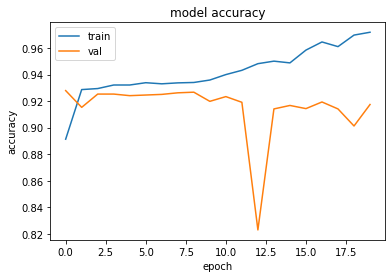

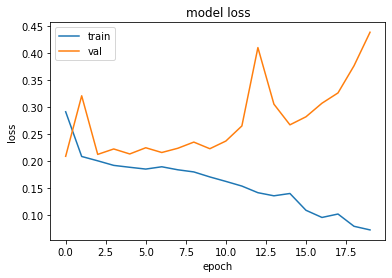

[[9337  244]
 [ 595  172]]
F1 score: 0.29078613693998306
Precision: 0.41346153846153844
Recall: 0.2242503259452412
Accuracy: 0.9189215307305759
ROC AUC: 0.5993916278510257


In [84]:
cnn(df_created_sin)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_552 (Dense)            (None, 200)               40600     
_________________________________________________________________
dropout_476 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_553 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_477 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_554 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_478 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 347us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.114671780759056;  accuracy of 0.7061259746551514; precision of 0.7061259746551514; recall of 0.7061259746551514; AUC of 0.7530465126037598;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 343us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.094005950226131;  accuracy of 0.7139797210693359; precision of 0.7139797210693359; recall of 0.7139797210693359; AUC of 0.7556100487709045;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 348us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.0283168500003925;  accuracy of 0.7496787309646606; precision of 0.7496787309646606; recall of 0.7496787309646606; AUC of 0.770697295665741;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


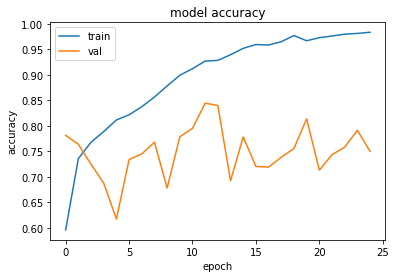

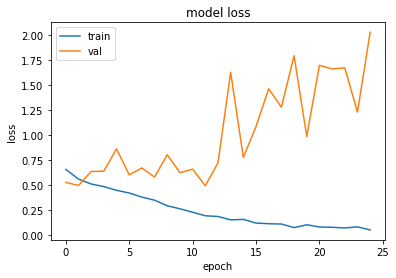

[[7195 2386]
 [ 248  519]]
F1 score: 0.28267973856209155
Precision: 0.17865748709122203
Recall: 0.6766623207301173
Accuracy: 0.7454580595284113
ROC AUC: 0.7138138865940536


In [85]:
nn_kfold(df_created_sin, balanced_batches=True)

Training data shape: (16807, 203)
Val data shape: (4202, 203)
Test data shape: (10348, 203)
Input shape: 202
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 202, 1)            0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 201, 32)           96        
_________________________________________________________________
batch_normalization_96 (Batc (None, 201, 32)           128       
_________________________________________________________________
conv1d_78 (Conv1D)           (None, 200, 32)           2080      
_________________________________________________________________
batch_normalization_97 (Batc (None, 200, 32)           128       
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 199, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 52s 662ms/step - loss: 0.7231 - accuracy: 0.6895 - precision: 0.6895 - recall: 0.6895 - AUC: 0.7523 - val_loss: 0.5413 - val_accuracy: 0.9260 - val_precision: 0.9260 - val_recall: 0.9260 - val_AUC: 0.9682
Epoch 2/20
79/79 [==============================] - 38s 483ms/step - loss: 0.5228 - accuracy: 0.7492 - precision: 0.7492 - recall: 0.7492 - AUC: 0.8294 - val_loss: 0.6133 - val_accuracy: 0.7901 - val_precision: 0.7901 - val_recall: 0.7901 - val_AUC: 0.8542
Epoch 3/20
79/79 [==============================] - 37s 474ms/step - loss: 0.4663 - accuracy: 0.7800 - precision: 0.7800 - recall: 0.7800 - AUC: 0.8613 - val_loss: 0.4981 - val_accuracy: 0.8946 - val_precision: 0.8946 - val_recall: 0.8946 - val_AUC: 0.9508
Epoch 4/20
79/79 [==============================] - 37s 470ms/step - loss: 0.4223 - accuracy: 0.8019 - precision: 0.8019 - recall: 0.8019 - AUC: 0.8861 - val_loss: 0.4498 - val_accuracy: 0.8582 - val_precision: 0.8582 - val_recal

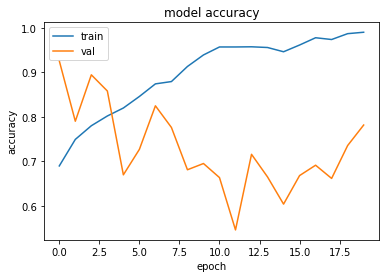

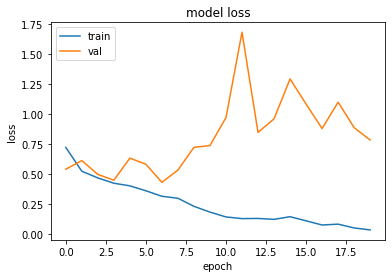

[[7626 1955]
 [ 291  476]]
F1 score: 0.29768605378361473
Precision: 0.1958041958041958
Recall: 0.6205997392438071
Accuracy: 0.7829532276768457
ROC AUC: 0.7082750287910925


In [86]:
cnn(df_created_sin, balanced_batches=True)

## All created + squared continous columns

In [87]:
df_raw_medain_75_ext.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_2,monthly_income_2,min_sedetary_2,lab_VitB12_2,bone_mineral_density_2,#_chronic_condition_2,hours_screen_2,combined_BP_2,people_per_rooms_2,diet_tot_VitB_2
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,1.0,49.0,90000.0,270400.0,1.227664,1.0,4.0,47524.0,0.250000,90249.172225
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,1.0,49.0,90000.0,270400.0,1.227664,4.0,4.0,39204.0,0.062500,663283.194084
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,1.0,49.0,90000.0,270400.0,1.227664,1.0,1.0,39204.0,0.081633,83303.236129
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,1.0,49.0,90000.0,270400.0,1.227664,4.0,64.0,30276.0,0.140625,95127.831184
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,1.0,49.0,90000.0,270400.0,1.227664,0.0,36.0,28900.0,0.183673,288015.762241


Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_581 (Dense)            (None, 200)               45200     
_________________________________________________________________
dropout_501 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_582 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_502 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_583 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_503 (Dropout)        (None, 100)               0         
__________

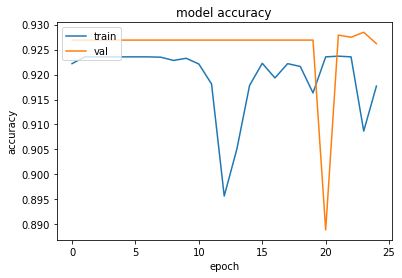

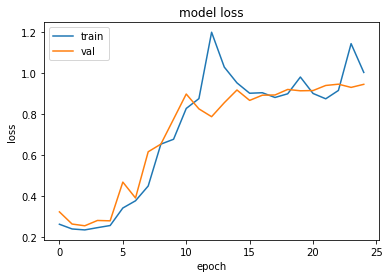

[[9417  164]
 [ 672   95]]
F1 score: 0.18518518518518517
Precision: 0.3667953667953668
Recall: 0.12385919165580182
Accuracy: 0.9192114418245072
ROC AUC: 0.55337099025437


In [88]:
nn_kfold(df_raw_medain_75_ext)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 225, 1)            0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 224, 32)           96        
_________________________________________________________________
batch_normalization_101 (Bat (None, 224, 32)           128       
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 223, 32)           2080      
_________________________________________________________________
batch_normalization_102 (Bat (None, 223, 32)           128       
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 222, 64)           4160      
__________

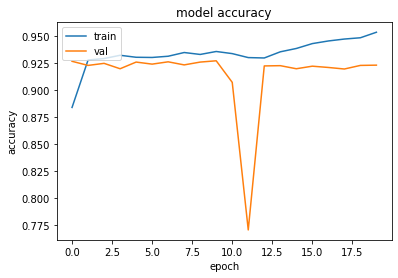

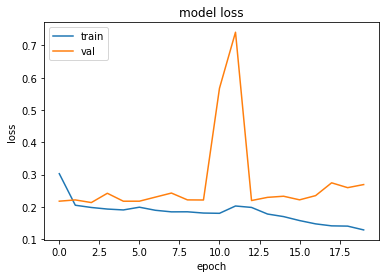

[[9369  212]
 [ 613  154]]
F1 score: 0.2718446601941748
Precision: 0.4207650273224044
Recall: 0.20078226857887874
Accuracy: 0.9202744491689215
ROC AUC: 0.58932757098707


In [89]:
cnn(df_raw_medain_75_ext)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_619 (Dense)            (None, 200)               45200     
_________________________________________________________________
dropout_534 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_620 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_535 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_536 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 3s 358us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.5778667105022166;  accuracy of 0.7358275055885315; precision of 0.7358275055885315; recall of 0.7358275055885315; AUC of 0.7727338671684265;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 3s 363us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.819365279258838;  accuracy of 0.7216907143592834; precision of 0.7216907143592834; recall of 0.7216907143592834; AUC of 0.7637510895729065;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 3s 368us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.357573746851848;  accuracy of 0.6699985861778259; precision of 0.6699985861778259; recall of 0.6699985861778259; AUC of 0.6961637139320374;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


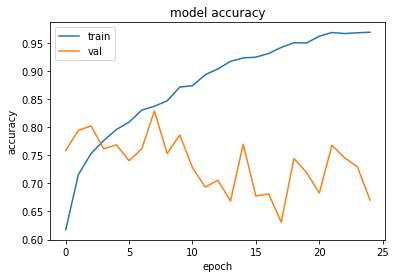

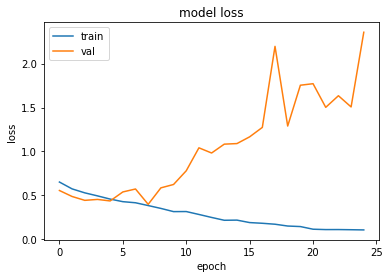

[[6193 3388]
 [ 199  568]]
F1 score: 0.24052508998517888
Precision: 0.1435793731041456
Recall: 0.7405475880052151
Accuracy: 0.6533629686896019
ROC AUC: 0.6934655276421023


In [91]:
nn_kfold(df_raw_medain_75_ext, balanced_batches=True)

Training data shape: (16807, 226)
Val data shape: (4202, 226)
Test data shape: (10348, 226)
Input shape: 225
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 225, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 224, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 223, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 223, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 222, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Epoch 1/12
79/79 [==============================] - 47s 593ms/step - loss: 0.6892 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - AUC: 0.7720 - val_loss: 0.7655 - val_accuracy: 0.0759 - val_precision: 0.0759 - val_recall: 0.0759 - val_AUC: 0.1147
Epoch 2/12
79/79 [==============================] - 40s 507ms/step - loss: 0.5147 - accuracy: 0.7460 - precision: 0.7460 - recall: 0.7460 - AUC: 0.8332 - val_loss: 0.7942 - val_accuracy: 0.1202 - val_precision: 0.1202 - val_recall: 0.1202 - val_AUC: 0.1251
Epoch 3/12
79/79 [==============================] - 40s 504ms/step - loss: 0.4631 - accuracy: 0.7855 - precision: 0.7855 - recall: 0.7855 - AUC: 0.8641 - val_loss: 0.8048 - val_accuracy: 0.2435 - val_precision: 0.2435 - val_recall: 0.2435 - val_AUC: 0.1970
Epoch 4/12
79/79 [==============================] - 57s 727ms/step - loss: 0.4137 - accuracy: 0.7995 - precision: 0.7995 - recall: 0.7995 - AUC: 0.8910 - val_loss: 0.6858 - val_accuracy: 0.5878 - val_precision: 0.5878 - val_reca

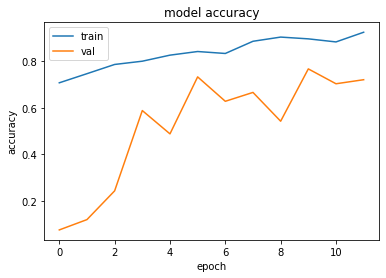

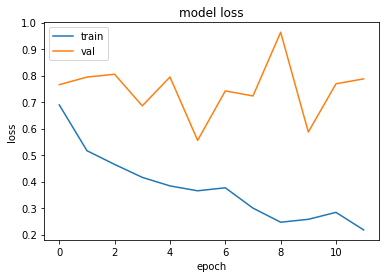

[[6873 2708]
 [ 216  551]]
F1 score: 0.2737208147044213
Precision: 0.16907026695305308
Recall: 0.7183833116036505
Accuracy: 0.7174333204483958
ROC AUC: 0.7178702905998631


In [23]:
EPOCHS_2 = 12
cnn(df_raw_medain_75_ext, balanced_batches=True)

## squared + log(n)

In [24]:
df_add_log = df_raw_medain_75_ext.copy()

cont, non_cont, cat_encode, = var_type(df_add_log)

# remove squared values from continous var list
og_cont = []
for i in range(len(cont)):
    if cont[i].endswith('_2') == False:
        og_cont.append(cont[i])

# log of all cont columns
for var in og_cont:
    df_add_log[str(var) + '_log'] = (df_add_log[var]-df_add_log[var].min()+1).transform(np.sqrt)


df_add_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_log,monthly_income_log,min_sedetary_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.000000,2.645751,9.000000,1.162604,23.187734


In [25]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# def draw_histograms(df, variables, n_rows, n_cols):
#     fig=plt.figure(figsize=(18,6))
#     for i, var_name in enumerate(variables):
#         ax=fig.add_subplot(n_rows,n_cols,i+1)
#         df[var_name].hist(bins=10,ax=ax)
#         ax.set_title(var_name+" Distribution")
#     #fig.tight_layout()  # Improves appearance a bit.
#     plt.show()

# check = ['diet_chol_log',
#  'VitB6_log',
#  'folate_log',
#  'VitB12_log',
#  'magnesium_log',
#  'iron_log',
#  'zinc_log',
#  'selenium_log',
#  'water_log',
#  'healthcare_past_yr_log']

# draw_histograms(df_add_log, check, 2, 5)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               55000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
___________

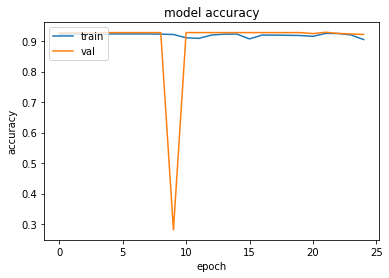

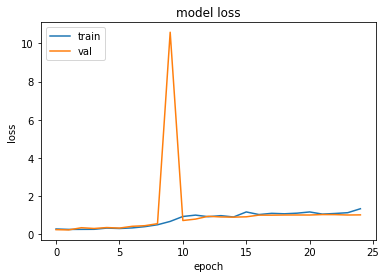

[[9405  176]
 [ 680   87]]
F1 score: 0.16893203883495145
Precision: 0.33079847908745247
Recall: 0.11342894393741851
Accuracy: 0.9172787011982992
ROC AUC: 0.5475296269629687


In [26]:
nn_kfold(df_add_log)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 274, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 273, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 273, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 272, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 272, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 271, 64)           4160      
___________

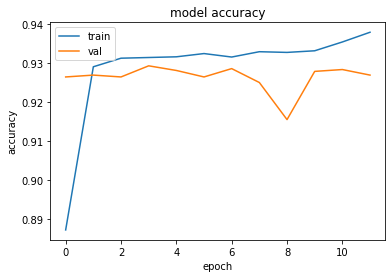

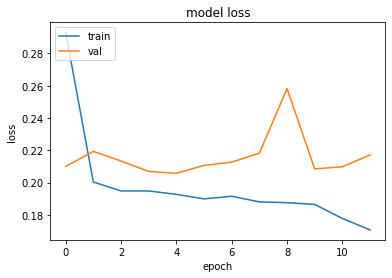

[[9453  128]
 [ 631  136]]
F1 score: 0.2638215324927255
Precision: 0.5151515151515151
Recall: 0.1773142112125163
Accuracy: 0.9266524932354078
ROC AUC: 0.5819772183293559


In [27]:
cnn(df_add_log)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               55000     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 171us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.9069886975299967;  accuracy of 0.7732400298118591; precision of 0.7732400298118591; recall of 0.7732400298118591; AUC of 0.8620191812515259;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 167us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.5332217193511184;  accuracy of 0.7138369083404541; precision of 0.7138369083404541; recall of 0.7138369083404541; AUC of 0.8049843311309814;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 181us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.453905046284071;  accuracy of 0.7632443308830261; precision of 0.7632443308830261; recall of 0.7632443308830261; AUC of 0.8189882040023804;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


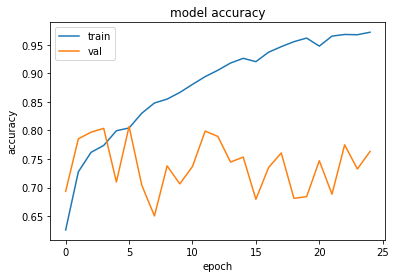

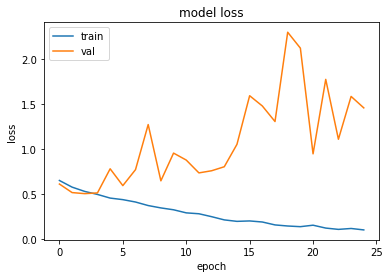

[[7262 2319]
 [ 238  529]]
F1 score: 0.2926694329183956
Precision: 0.1857443820224719
Recall: 0.6897001303780965
Accuracy: 0.7528991109393119
ROC AUC: 0.7238292949145466


In [28]:
nn_kfold(df_add_log, balanced_batches=True)

Training data shape: (16807, 275)
Val data shape: (4202, 275)
Test data shape: (10348, 275)
Input shape: 274
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 274, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 273, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 273, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 272, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 272, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 271, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/12
79/79 [==============================] - 67s 850ms/step - loss: 0.6846 - accuracy: 0.6962 - precision: 0.6962 - recall: 0.6962 - AUC: 0.7578 - val_loss: 0.5322 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9671
Epoch 2/12
79/79 [==============================] - 51s 648ms/step - loss: 0.5063 - accuracy: 0.7592 - precision: 0.7592 - recall: 0.7592 - AUC: 0.8354 - val_loss: 0.6245 - val_accuracy: 0.8084 - val_precision: 0.8084 - val_recall: 0.8084 - val_AUC: 0.8797
Epoch 3/12
79/79 [==============================] - 57s 718ms/step - loss: 0.4665 - accuracy: 0.7827 - precision: 0.7827 - recall: 0.7827 - AUC: 0.8593 - val_loss: 0.4488 - val_accuracy: 0.9131 - val_precision: 0.9131 - val_recall: 0.9131 - val_AUC: 0.9598
Epoch 4/12
79/79 [==============================] - 67s 844ms/step - loss: 0.4428 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - AUC: 0.8741 - val_loss: 0.7181 - val_accuracy: 0.5704 - val_precision: 0.5704 - val_recal

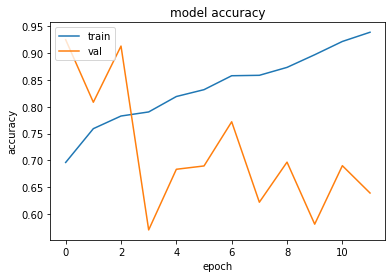

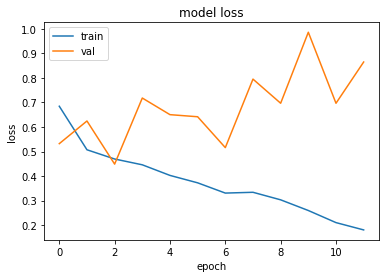

[[5985 3596]
 [ 203  564]]
F1 score: 0.22894256139638725
Precision: 0.13557692307692307
Recall: 0.7353324641460235
Accuracy: 0.6328759180517974
ROC AUC: 0.6800031488875404


In [29]:
cnn(df_add_log, balanced_batches=True)

## squared + log + square root

In [30]:
df_add_sqrt = df_add_log.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sqrt[str(var) + '_sqrt'] = (df_add_sqrt[var]-df_add_sqrt[var].min()+1).transform(np.sqrt)


df_add_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sqrt,monthly_income_sqrt,min_sedetary_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,1.414214,2.645751,17.349352,22.427661,1.172604,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 200)               64800     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_53 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
__________

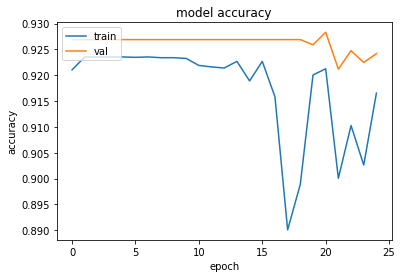

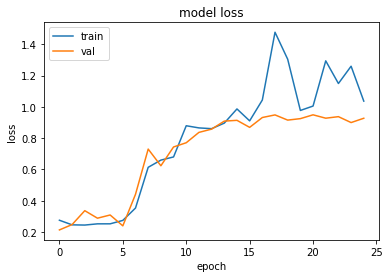

[[9413  168]
 [ 673   94]]
F1 score: 0.1827016520894072
Precision: 0.35877862595419846
Recall: 0.12255541069100391
Accuracy: 0.9187282566679552
ROC AUC: 0.5525103532945678


In [31]:
nn_kfold(df_add_sqrt)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 323, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 322, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 322, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 321, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 321, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 320, 64)           4160      
__________

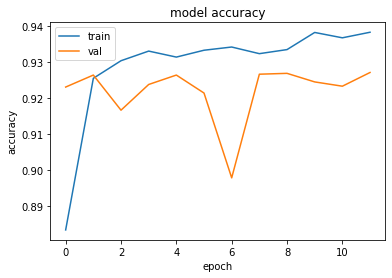

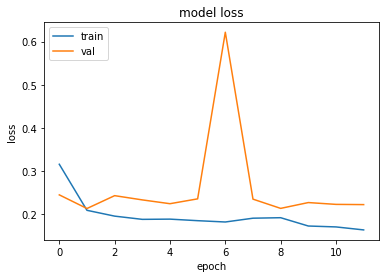

[[9409  172]
 [ 616  151]]
F1 score: 0.27706422018348625
Precision: 0.4674922600619195
Recall: 0.196870925684485
Accuracy: 0.9238500193274063
ROC AUC: 0.5894593643139051


In [32]:
cnn(df_add_sqrt)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 200)               64800     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_78 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_79 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 226us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.3494064631707903;  accuracy of 0.7022704482078552; precision of 0.7022704482078552; recall of 0.7022704482078552; AUC of 0.7730470299720764;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 240us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0100747452503305;  accuracy of 0.7802370190620422; precision of 0.7802370190620422; recall of 0.7802370190620422; AUC of 0.8719701170921326;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 246us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.2173631035837296;  accuracy of 0.7605311870574951; precision of 0.7605311870574951; recall of 0.7605311870574951; AUC of 0.8385899662971497;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


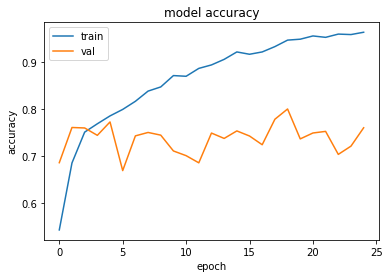

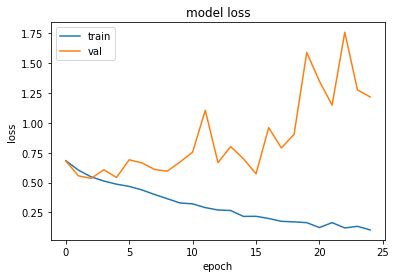

[[7383 2198]
 [ 273  494]]
F1 score: 0.28563168545822487
Precision: 0.18350668647845467
Recall: 0.6440677966101694
Accuracy: 0.7612098956320061
ROC AUC: 0.7073277089720298


In [33]:
nn_kfold(df_add_sqrt, balanced_batches=True)

Training data shape: (16807, 324)
Val data shape: (4202, 324)
Test data shape: (10348, 324)
Input shape: 323
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 323, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 322, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 322, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 321, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 321, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 320, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/12
79/79 [==============================] - 65s 826ms/step - loss: 0.7219 - accuracy: 0.6907 - precision: 0.6907 - recall: 0.6907 - AUC: 0.7587 - val_loss: 1.5430 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1102
Epoch 2/12
79/79 [==============================] - 57s 716ms/step - loss: 0.5001 - accuracy: 0.7644 - precision: 0.7644 - recall: 0.7644 - AUC: 0.8419 - val_loss: 1.6736 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.1088
Epoch 3/12
79/79 [==============================] - 57s 722ms/step - loss: 0.4671 - accuracy: 0.7835 - precision: 0.7835 - recall: 0.7835 - AUC: 0.8613 - val_loss: 1.1118 - val_accuracy: 0.0985 - val_precision: 0.0985 - val_recall: 0.0985 - val_AUC: 0.1135
Epoch 4/12
79/79 [==============================] - 57s 724ms/step - loss: 0.4271 - accuracy: 0.8111 - precision: 0.8111 - recall: 0.8111 - AUC: 0.8838 - val_loss: 1.1435 - val_accuracy: 0.1397 - val_precision: 0.1397 - val_recal

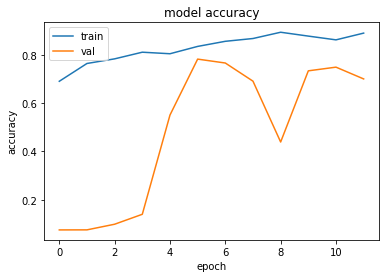

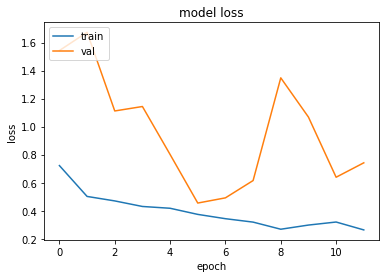

[[6574 3007]
 [ 214  553]]
F1 score: 0.25560434481164773
Precision: 0.1553370786516854
Recall: 0.7209908735332464
Accuracy: 0.6887321221492075
ROC AUC: 0.7035702723787722


In [34]:
cnn(df_add_sqrt, balanced_batches=True)

## " " + polynomial

In [35]:
df_add_poly = df_add_sqrt.copy()

# original continuous variables is og_cont

# 1+5x+8x2
for var in og_cont:
    df_add_poly[str(var) + '_poly'] = (1+(5*df_add_poly[var])+(8*np.power(df_add_poly[var],2)))


df_add_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_poly,monthly_income_poly,min_sedetary_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,14.0,428.0,721501.0,2165801.0,16.361312,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,14.0,428.0,721501.0,2165801.0,16.361312,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,14.0,428.0,721501.0,2165801.0,16.361312,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,14.0,428.0,721501.0,2165801.0,16.361312,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,14.0,428.0,721501.0,2165801.0,16.361312,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 200)               74600     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_103 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_104 (Dropout)        (None, 100)               0         
__________

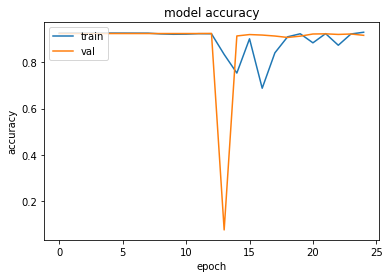

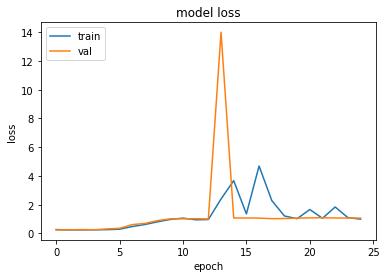

[[9396  185]
 [ 673   94]]
F1 score: 0.1797323135755258
Precision: 0.33691756272401435
Recall: 0.12255541069100391
Accuracy: 0.9170854271356784
ROC AUC: 0.5516231807656041


In [36]:
nn_kfold(df_add_poly)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 372, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 371, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 371, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 370, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 370, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 369, 64)           4160      
__________

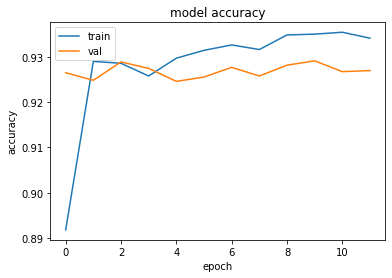

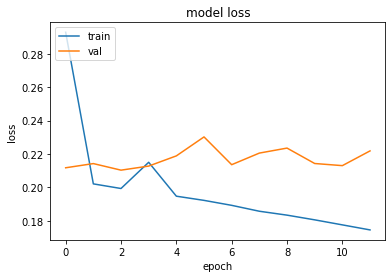

[[9436  145]
 [ 621  146]]
F1 score: 0.27599243856332706
Precision: 0.5017182130584192
Recall: 0.19035202086049544
Accuracy: 0.9259760340162351
ROC AUC: 0.5876089506243819


In [37]:
cnn(df_add_poly)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 200)               74600     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_128 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_129 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 273us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.3143208560885047;  accuracy of 0.692703127861023; precision of 0.692703127861023; recall of 0.692703127861023; AUC of 0.7364852428436279;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 248us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.4544401420927995;  accuracy of 0.718120813369751; precision of 0.718120813369751; recall of 0.718120813369751; AUC of 0.789844274520874;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 269us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.4950610617646214;  accuracy of 0.7092674374580383; precision of 0.7092674374580383; recall of 0.7092674374580383; AUC of 0.7695966958999634;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


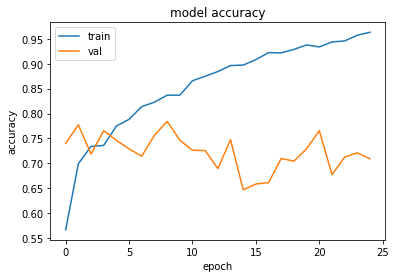

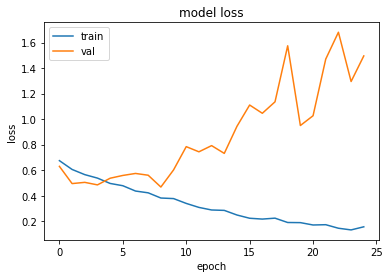

[[6558 3023]
 [ 215  552]]
F1 score: 0.2542607093505297
Precision: 0.1544055944055944
Recall: 0.7196870925684485
Accuracy: 0.6870892926169309
ROC AUC: 0.7020833959867605


In [38]:
nn_kfold(df_add_poly, balanced_batches=True)

Training data shape: (16807, 373)
Val data shape: (4202, 373)
Test data shape: (10348, 373)
Input shape: 372
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 372, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 371, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 371, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 370, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 370, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 369, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/12
79/79 [==============================] - 76s 961ms/step - loss: 0.6560 - accuracy: 0.7081 - precision: 0.7081 - recall: 0.7081 - AUC: 0.7741 - val_loss: 1.0173 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1151
Epoch 2/12
79/79 [==============================] - 65s 821ms/step - loss: 0.5031 - accuracy: 0.7616 - precision: 0.7616 - recall: 0.7616 - AUC: 0.8389 - val_loss: 1.0619 - val_accuracy: 0.0754 - val_precision: 0.0754 - val_recall: 0.0754 - val_AUC: 0.1107
Epoch 3/12
79/79 [==============================] - 65s 827ms/step - loss: 0.4609 - accuracy: 0.7827 - precision: 0.7827 - recall: 0.7827 - AUC: 0.8636 - val_loss: 1.0289 - val_accuracy: 0.0785 - val_precision: 0.0785 - val_recall: 0.0785 - val_AUC: 0.1153
Epoch 4/12
79/79 [==============================] - 65s 827ms/step - loss: 0.4167 - accuracy: 0.8115 - precision: 0.8115 - recall: 0.8115 - AUC: 0.8906 - val_loss: 0.7399 - val_accuracy: 0.4867 - val_precision: 0.4867 - val_recal

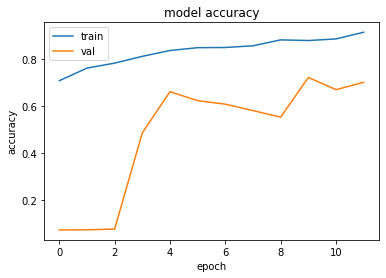

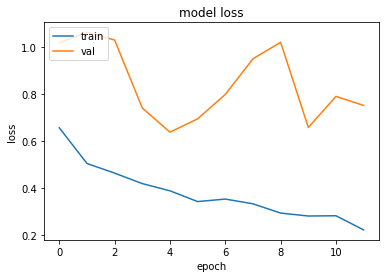

[[6659 2922]
 [ 212  555]]
F1 score: 0.2615457115928369
Precision: 0.15962036238136323
Recall: 0.7235984354628422
Accuracy: 0.6971395438732122
ROC AUC: 0.7093099159883879


In [39]:
cnn(df_add_poly, balanced_batches=True)

## " " + sin(n)

In [40]:
df_add_sin = df_add_poly.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sin[str(var) + '_sin'] = (df_add_sin[var]-df_add_sin[var].min()+1).transform(np.sin)


df_add_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,#meals_fast_food_sin,monthly_income_sin,min_sedetary_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,0.909297,0.656987,-0.558764,0.338362,0.980893,0.909297,0.141120,-0.193473,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,0.909297,0.656987,-0.558764,0.338362,0.980893,0.141120,0.141120,0.816743,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.0,1.0,...,0.909297,0.656987,-0.558764,0.338362,0.980893,0.909297,0.909297,0.816743,0.935189,0.561730
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.0,5.0,...,0.909297,0.656987,-0.558764,0.338362,0.980893,0.141120,0.412118,-0.176076,0.963042,0.999822
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.0,5.0,...,0.909297,0.656987,-0.558764,0.338362,0.980893,0.841471,0.656987,-0.629888,0.976083,-0.442744


Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 200)               84400     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_153 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_154 (Dropout)        (None, 100)               0         
__________

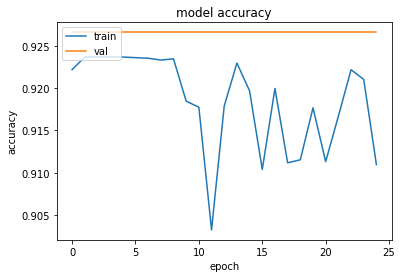

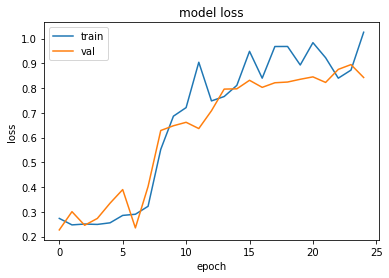

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
nn_kfold(df_add_sin)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 421, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 420, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 420, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 419, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 419, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 418, 64)           4160      
__________

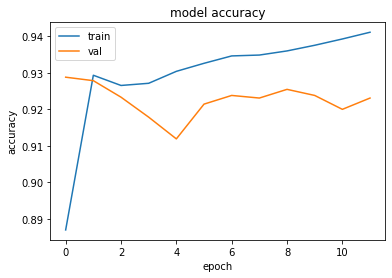

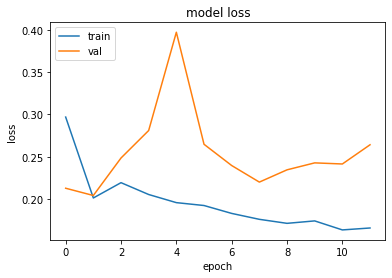

[[9449  132]
 [ 642  125]]
F1 score: 0.244140625
Precision: 0.48638132295719844
Recall: 0.16297262059973924
Accuracy: 0.9252029377657518
ROC AUC: 0.5745976765455643


In [42]:
cnn(df_add_sin)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 200)               84400     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_178 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_179 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 3s 386us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.5770290169088768;  accuracy of 0.7692417502403259; precision of 0.7692417502403259; recall of 0.7692417502403259; AUC of 0.8063802719116211;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 263us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.7659931593701854;  accuracy of 0.763529896736145; precision of 0.763529896736145; recall of 0.763529896736145; AUC of 0.856017529964447;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 278us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.5390486668879928;  accuracy of 0.67970871925354; precision of 0.67970871925354; recall of 0.67970871925354; AUC of 0.7558431625366211;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


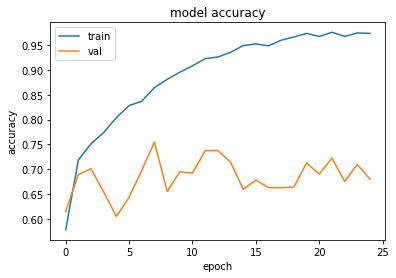

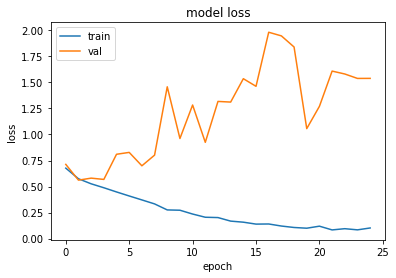

[[6453 3128]
 [ 232  535]]
F1 score: 0.2415349887133183
Precision: 0.14605514605514605
Recall: 0.6975228161668839
Accuracy: 0.6752995747970623
ROC AUC: 0.6855216627541445


In [43]:
nn_kfold(df_add_sin, balanced_batches=True)

Training data shape: (16807, 422)
Val data shape: (4202, 422)
Test data shape: (10348, 422)
Input shape: 421
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 421, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 420, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 420, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 419, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 419, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 418, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/12
79/79 [==============================] - 83s 1s/step - loss: 0.7253 - accuracy: 0.7002 - precision: 0.7002 - recall: 0.7002 - AUC: 0.7530 - val_loss: 2.1166 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1129
Epoch 2/12
79/79 [==============================] - 74s 931ms/step - loss: 0.5106 - accuracy: 0.7564 - precision: 0.7564 - recall: 0.7564 - AUC: 0.8337 - val_loss: 2.1889 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1167
Epoch 3/12
79/79 [==============================] - 73s 929ms/step - loss: 0.4534 - accuracy: 0.7919 - precision: 0.7919 - recall: 0.7919 - AUC: 0.8684 - val_loss: 1.4836 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1180
Epoch 4/12
79/79 [==============================] - 73s 921ms/step - loss: 0.4071 - accuracy: 0.8171 - precision: 0.8171 - recall: 0.8171 - AUC: 0.8953 - val_loss: 1.2162 - val_accuracy: 0.1349 - val_precision: 0.1349 - val_recall: 

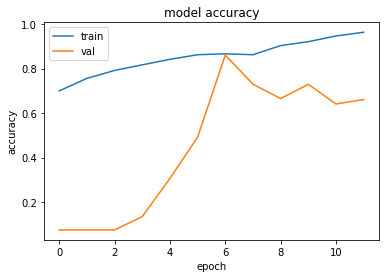

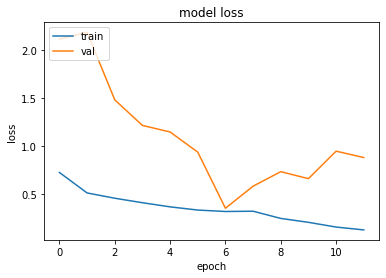

[[6208 3373]
 [ 197  570]]
F1 score: 0.24203821656050956
Precision: 0.14455997971088005
Recall: 0.7431551499348109
Accuracy: 0.6550057982218787
ROC AUC: 0.6955521078971623


In [44]:
cnn(df_add_sin, balanced_batches=True)